# Supplementary Figures
This notebook will present analyses and discussions of the GH-VAP project looking for potential microbiome causes/associations with individuals who produce broadly neutralizing antibodies to HIV; as well as everything else I can learn from the transcriptome. 

This specific notebook will handle the code to generate supplementary figures.

## Author: 
 **Mark Kowarsky**
 
 - **Date Updated:** 2018-10-24


#### Code cleaned by:
- Mercedes Dalman
- **Date Updated:** 2025-09

## Imports and stylings

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import HTSeq
import glob
import itertools
from collections import defaultdict
import matplotlib.dates as mdates
from collections import defaultdict
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests


#from wordcloud import WordCloud
from matplotlib.colors import to_hex

from ete3 import NCBITaxa, TreeStyle, NodeStyle, faces

from IPython.core.pylabtools import figsize

from scipy.interpolate import PchipInterpolator
from scipy.stats.mstats import spearmanr

from sklearn import decomposition, manifold

from adjustText import adjust_text


from pathlib import Path
import os, re

import pysam


#%load_ext rpy2.ipython

In [2]:
plt.rcParams["svg.fonttype"] = "path"   # makes text outlines (font-safe)
plt.rcParams["pdf.fonttype"] = 42       # embeds TrueType fonts in PDF (also safe)
plt.rcParams["ps.fonttype"] = 42

In [3]:
# Colours from Material Design - https://material.io/tools/color/
green = "#388e3c"
light_green = "#6abf69"
dark_green = "#00600f"

blue = "#1976d2"
light_blue = "#63a4ff"
dark_blue = "#004ba0"

red = "#d32f2f"
light_red = "#ff6659"
dark_red = "#9a0007"

yellow = "#fbc02d"
light_yellow = "#fff263"
dark_yellow = "#c49000"

grey = "#616161"
light_grey = "#8e8e8e"
dark_grey = "#373737"

orange = "#f57c00"
light_orange = "#ffad42"
dark_orange = "#bb4d00"

purple = "#7b1fa2"
dark_purple = "#4a0072"
light_purple = "#ae52d4"

## HIV/AIDS statistics figures

## Breadth of broadly neutralizing antibodies

In [4]:
breadth_metadata = pd.read_excel("../tables/Gates_metadata.xlsx", index_col=[22, 23])
breadth_metadata.index = ["_".join(map(str,x)) for x in breadth_metadata.index]
breadth_metadata["Patient"] = [x.split("_")[0] for x in breadth_metadata.index]
breadth_metadata["sample"] = "SAMPLE_" + breadth_metadata["Patient"] + "_" + breadth_metadata["Years PI"].astype(str)
breadth_metadata.set_index("sample", inplace=True)

In [5]:
def convert_less_than(x):
    if isinstance(x, str) and "<" in x:
        return 0
    else:
        return float(x)

In [7]:
design = pd.read_table("../tables/edgeR_design.txt", index_col=0)

a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [8]:
meta1 = pd.read_excel("../tables/Gates_metadata.xlsx", sheet_name=1)
meta1["sample"] = "SAMPLE_" + meta1["PID"].astype(str) + 14*["_1", "_2", "_3"]
meta1.set_index("sample", inplace=True)

## FigureS1 - Clinical Information on Blood Samples


In [9]:
meta2 = pd.read_excel("../tables/Gates_metadata.xlsx", sheet_name=2)
meta2.sort_values(by=["PID", "Specimen Collection Date"], inplace=True)

In [10]:
a = list(design.query("bNAbs == 'Y'").index)[::3]
b = list(design.query("bNAbs == 'N'").index)[::3]
c = a + b
c[::2] = a
c[1::2] = b

In [11]:
def plot_HIV_timeseries(df, ax=None, cd4_color=orange, viralload_color=purple):
    if ax is None:
        ax = plt.gca()
    
    # Extra information from the dataframe
    t = df["Specimen Collection Date"]
    n = df["PID"].iloc[0]
    cd4  = df["CD4 count"]
    vl = df["Viral Load"]
    
    # Find time domain, with month buffers
    infection = df["Date of infection"].iloc[0]
    art = meta1[meta1["PID"] == n]["ART date"].iloc[0]
    start_time = infection
    if art == ".":
        end_time = t.max()
    else:
        end_time = max(t.max(), art)
    T = pd.date_range(t.min(), t.max())
    
    # Plot CD4 counts
    ax.plot(T, PchipInterpolator(t, cd4)(T), linewidth=4, zorder=10, alpha=0.8, color=cd4_color)
    ax.axhspan(ymin=0, ymax=200, color=light_grey, alpha=0.5)
    ax.set_ylim(0, 1200)
    ax.tick_params('y', colors=cd4_color, labelsize=14)
    
    # Plot viral load
    ax2 = ax.twinx()
    ax2.plot(T, PchipInterpolator(t, vl)(T), linewidth=4, zorder=10, alpha=0.8, color=viralload_color)
    ax2.set_ylim(1e2, 1e7)
    ax2.set_yscale("log")
    ax2.tick_params('y', colors=viralload_color, labelsize=14)

    # Plasma times
    for p in meta1[meta1["PID"] == n]["vdate"]:
        s = meta1.loc[meta1[meta1["PID"] == n].query("vdate == '{}'".format(p)).index]
        ax.scatter(p, s["CD4"], zorder=100, marker="D", s=64, color=dark_orange)
        ax2.scatter(p, s["viralload"], zorder=100, marker="D", s=64, color=dark_purple)
    
    # Year ticks
    for y in pd.date_range(start_time, end_time, freq="AS"):
        ax.axvline(y, ymax=0.05, linewidth=1, color='k')
    
    # Extra annotations
    ax.annotate(str(n), xy=(0.5, 1), xycoords="axes fraction",
            ha="center", va="bottom", fontsize=16)
    ax.set_xlim(start_time, end_time)
    sns.despine(right=False)
    ax.set_xticks([])
    ax2.set_xticks([])

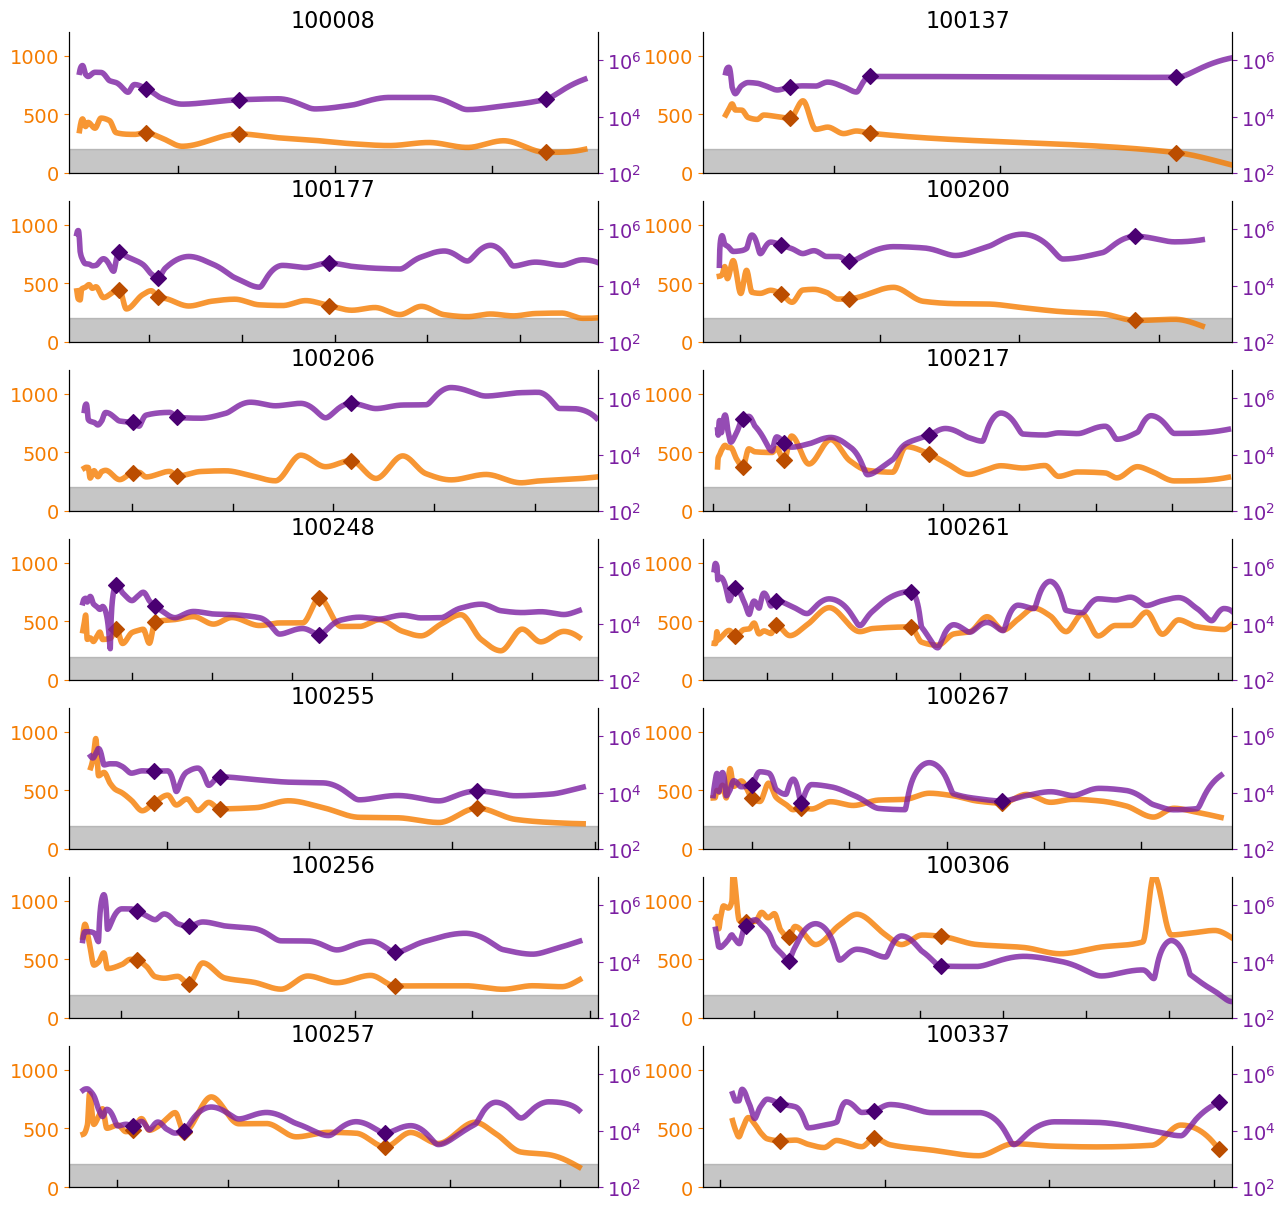

In [12]:
import warnings
warnings.filterwarnings("ignore")


figsize(15, 15)
f, axarr = plt.subplots(nrows=7, ncols=2)

for i, p in enumerate([i.split("_")[1] for i in c]):
    g = meta2.query("PID == {}".format(p)).dropna()
    plot_HIV_timeseries(g, ax=axarr.reshape(-1)[i])
os.makedirs('../figures/sfigures/sfigure1', exist_ok = True)
plt.savefig("../figures/sfigures/sfigure1/s2_time_series.svg")
plt.show()

# Figure S2

## Basic statistics

In [13]:
rsa = pd.read_table("../tables/samples/rSA.csv", index_col=0)
sa = pd.read_table("../tables/samples/SA.csv", index_col=0)

In [14]:
pre = pd.read_table("../tables/preprocess_stats.txt", index_col=0)

pre["group"] = [i.strip("B") if (i.endswith("B") and i != "Water_B") else i for i in pre.index]
pre = pre.groupby("group").sum()

# Non-human counts
nh = pd.read_table("../tables/not_human_stats.txt", names=["sample", "type", "end", "stat"])
nh["type"] = nh["type"] + "_" + nh["end"]
nh = nh.pivot(index="sample", columns="type", values="stat")

nh["group"] = [i.strip("B") if (i.endswith("B") and i != "Water_B") else i for i in nh.index]
nh = nh.groupby("group").sum()

In [15]:
# Order of samples
a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [16]:
pre_rsa = pd.DataFrame(index=rsa.index, columns=["raw", "cleaned", "nonhuman"])
pre_rsa.loc[rsa.index, "raw"] = pre.loc[rsa.index, "raw_fastq.1"]
pre_rsa.loc[rsa.index, "cleaned"] = 100-\
                                    100*(pre.loc[rsa.index, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))/pre.loc[rsa.index, 
                                                    ["raw_fastq.1", "raw_fastq.U"]].sum(axis=1)
pre_rsa.loc[rsa.index, "cleaned_counts"] = (pre.loc[rsa.index, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))
pre_rsa.loc[rsa.index, "nonhuman"] = 100*(nh.loc[rsa.index, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1))/pre.loc[rsa.index, 
                                                    ["cleaned_fastq.1", "cleaned_fastq.U"]].sum(axis=1)
pre_rsa["human"] = 100 - pre_rsa["nonhuman"]
pre_rsa["human_counts"] = pre_rsa["cleaned_counts"] - nh.loc[rsa.index, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1)

pre_rsa = pre_rsa.sort_index()
pre_rsa["Subject"] = [i.split("_")[1] for i in pre_rsa.index]
pre_rsa["Subject"] = [i[:-1] if "water" in i else i for i in pre_rsa["Subject"]]

pre_rsa = pre_rsa.loc[c + list(rsa.index.difference(c))] # Preserve order from before

In [17]:
meta1["other_name"] = meta1["PID"].astype(str) + "_" + meta1["visit code"].astype(str)
meta1["old_name"] = meta1.index
m = meta1.set_index("other_name")

In [18]:
I = sa.index.intersection(pre.index).intersection(nh.index)
pre_sa = pd.DataFrame(index=I, columns=["raw", "cleaned", "nonhuman"])
pre_sa.loc[I, "raw"] = pre.loc[I, "raw_fastq.1"]
pre_sa.loc[I, "cleaned"] = 100-\
                                    100*(pre.loc[I, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))/pre.loc[I, 
                                                    ["raw_fastq.1", "raw_fastq.U"]].sum(axis=1)
pre_sa.loc[I, "cleaned_counts"] = pre.loc[I, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1)
    
pre_sa.loc[I, "nonhuman"] = 100*(nh.loc[I, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1))/pre.loc[I, 
                                                    ["cleaned_fastq.1", "cleaned_fastq.U"]].sum(axis=1)
pre_sa["human"] = 100 - pre_sa["nonhuman"]

pre_sa.loc["100206_4230"] = np.nan
pre_sa.loc["100306_3090"] = np.nan

pre_sa = pre_sa.sort_index()
pre_sa["Subject"] = [i.split("_")[0] for i in pre_sa.index]
pre_sa.index = [m.loc[i, "old_name"] for i in pre_sa[pre_sa["Subject"] != "Water"].index] + \
  list(pre_sa[pre_sa["Subject"] == "Water"].index)

In [19]:
def plot_stats(data, column,sample, color="k", yscale=None, ylim=None, savefig=None):
   
    data = data[data.Subject != 'NTC'].copy()
    subject_order = [
    "100008",
    "100137",
    "100177",
    "100200",
    "100206",
    "100217",
    "100248",
    "100255",
    "100256",
    "100257",
    "100261",
    "100267",
    "100306",
    "100337",
    "water",
    ]
    sample_order = []

    for pid in subject_order:
        if pid == "water":
            if sample == 'rna':
                # adjust depending on how many water samples you have
                sample_order += [
                    "SAMPLE_water1_1",
                    "SAMPLE_water2_1",
                    "SAMPLE_water3_1",
                    "SAMPLE_water4_1",
                    "SAMPLE_water5_1",
                    "SAMPLE_water6_1",
                ]
            elif sample == 'dna':
                sample_order += ['Water_A','Water_A16', 'Water_A8', 'Water_B', 'Water_B16', 'Water_B8']
                
        else:
            sample_order += [
                f"SAMPLE_{pid}_1",
                f"SAMPLE_{pid}_2",
                f"SAMPLE_{pid}_3",
            ]

    data = data.reindex(sample_order)

    x = data[column].copy()
    figsize(len(x)/3, 2)
    x.plot.bar(color=color)
    
    if ylim is not None:
        plt.ylim(*ylim)

    if yscale is not None:
        plt.yscale(yscale)
    
    for i in range(14):
        if (i % 2) == 1:
            plt.axvspan(xmin=i*3-0.5, xmax=(i+1)*3-0.5, zorder=0, color=grey, alpha=0.3)
    
    xlocs = list(np.arange(14)*3+1) + [44.5]
    xticks = list(data["Subject"].unique()) 
    plt.xticks(xlocs, xticks)
    plt.xlabel('')
    sns.despine()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

### Panel A

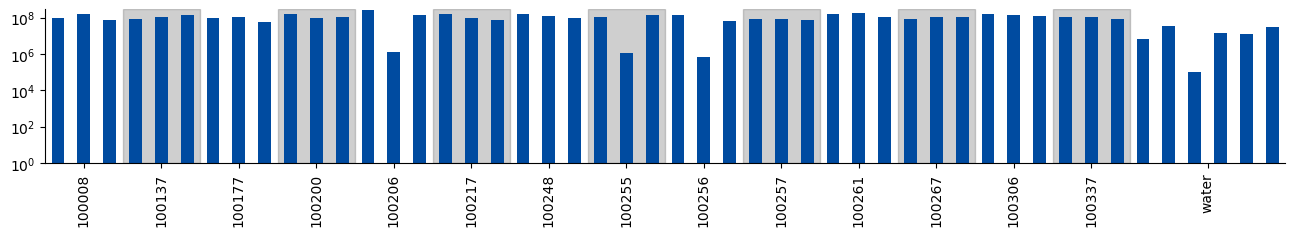

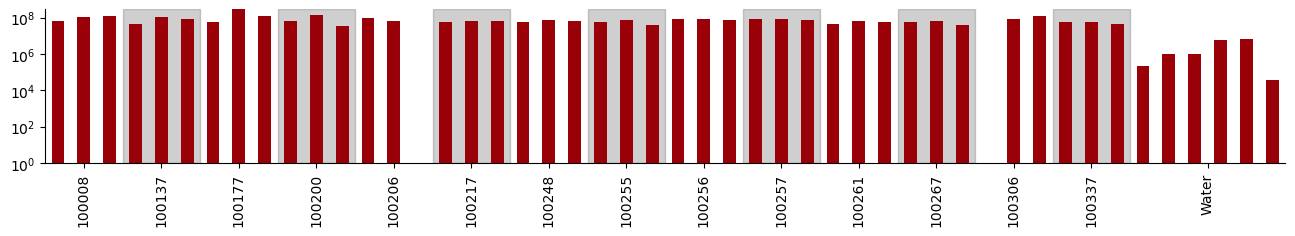

In [20]:
# Rows of bar charts for each sample, aligned to be the same size
r = pre_rsa.query("Subject != 'NTC'")
d = pre_sa

# A: no. sequenced fragments
os.makedirs('../figures/sfigures/sfigure2/panel_A/', exist_ok=True)
plot_stats(r,"raw", sample = 'rna', color=dark_blue, yscale="log", ylim=(1, 3e8), savefig="../figures/sfigures/sfigure2/panel_A/rna_counts.svg")
plot_stats(d,"raw", sample = 'dna',color=dark_red, yscale="log", ylim=(1, 3e8), savefig="../figures/sfigures/sfigure2/panel_A/dna_counts.svg")

### Panel B

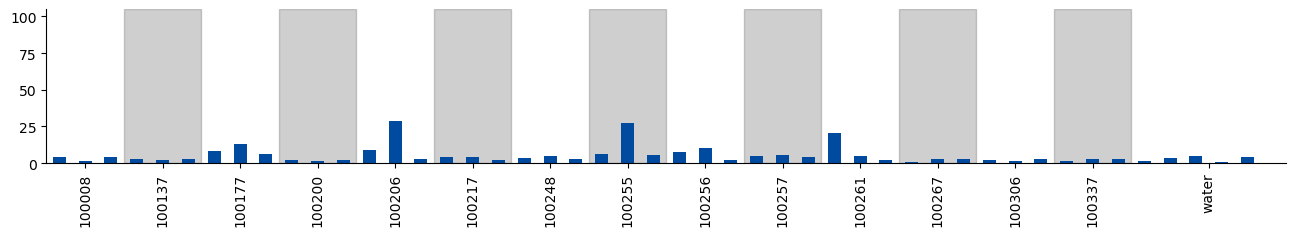

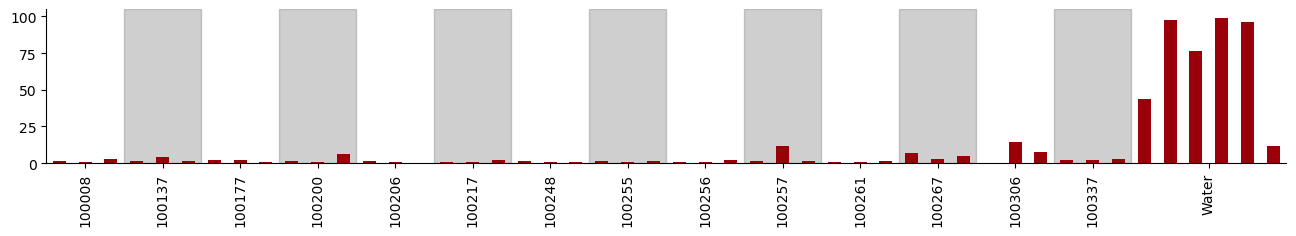

In [21]:
# B: % cleaned
os.makedirs('../figures/sfigures/sfigure2/panel_B/', exist_ok=True)
plot_stats(r,"cleaned", sample = 'rna', color=dark_blue, ylim=(0, 105), savefig="../figures/sfigures/sfigure2/panel_B/rna_cleaned.svg")
plot_stats(d,"cleaned", sample = 'dna', color=dark_red, ylim=(0, 105), savefig="../figures/sfigures/sfigure2/panel_B/dna_cleaned.svg")

### Panel C

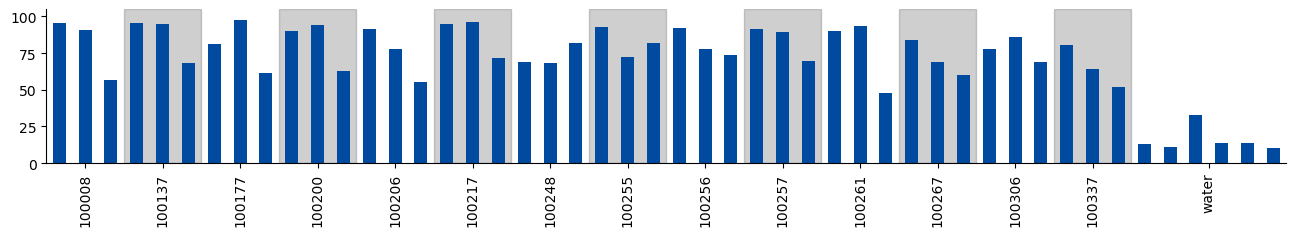

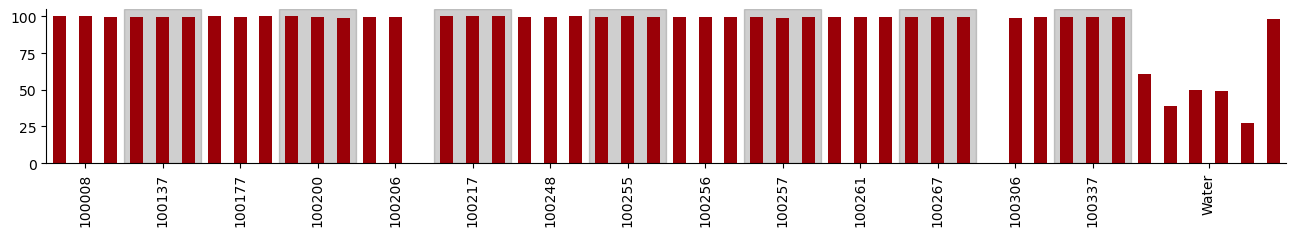

In [22]:
# C: % human
os.makedirs('../figures/sfigures/sfigure2/panel_C/', exist_ok=True)
plot_stats(r,"human", 'rna', color=dark_blue, ylim=(0, 105), savefig="../figures/sfigures/sfigure2/panel_C/rna_human.svg")
plot_stats(d,"human", 'dna', color=dark_red, ylim=(0, 105), savefig="../figures/sfigures/sfigure2/panel_C/dna_human.svg")

### Panel D

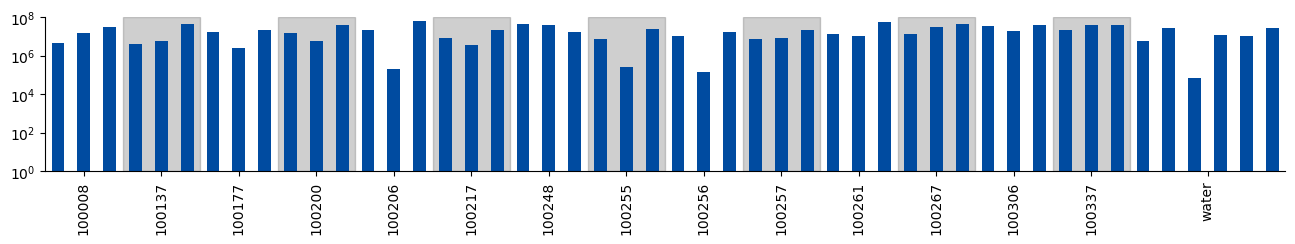

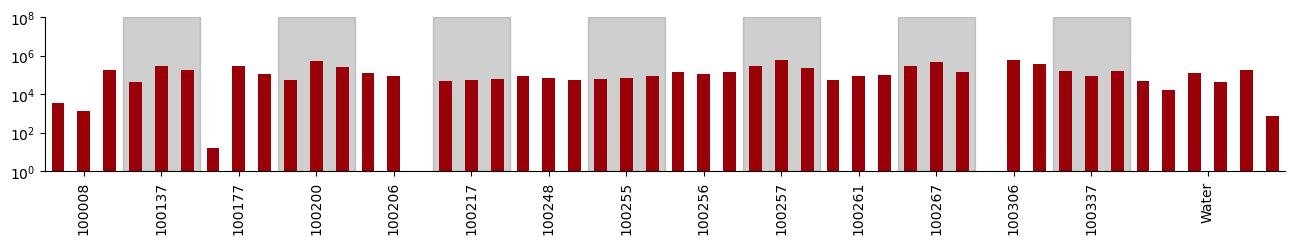

In [23]:
# D: No. nonhuman

os.makedirs('../figures/sfigures/sfigure2/panel_D/', exist_ok=True)
tmp = pd.DataFrame(nh[["human_genome_fastq.1", "human_genome_fastq.U"]].sum(axis=1).loc[r.index]).rename(columns={0:'non_human'})
tmp['Subject'] = r['Subject'].copy()
plot_stats(tmp,'non_human','rna', color=dark_blue, yscale="log", ylim=(1, 1e8), savefig="../figures/sfigures/sfigure2/panel_D/rna_nonhuman.svg")

tmp = pd.DataFrame(nh[["human_genome_fastq.1", "human_genome_fastq.U"]].sum(axis=1).reindex(
    list(meta1.loc[pre_sa.index[:-6], "other_name"]) + list(pre_sa.index[-6:]))).rename(columns={0:'non_human'})
tmp['Subject'] = d['Subject'].values
tmp.index = d.index

plot_stats(tmp,'non_human','dna', color=dark_red, yscale="log", ylim=(1, 1e8), savefig="../figures/sfigures/sfigure2/panel_D/dna_nonhuman.svg")

# S3 - Sequencing quality control metrics summarized by study group

# S4 - Cell-type deconvolution analysis of cfRNA

In [24]:
# Load big df with deconvoluted samples
df_nnls = pd.read_csv('../tables/all_deconvolutionCoefs_with_nnls.csv')
df_nnls.head(4)

,sample_id,row_name,method,platelet,erythroid,neutrophil,monocyte,macrophage,myeloid prog,dendritic cell,...,HSPC,thymocyte,adventitial cell,fibroblast/mesenchymal stem cell,pericyte cell,smooth muscle cell,stromal cell,endothelial cell,r,rmse
0,SAMPLE_100008_1,SAMPLE_100008_1-NNLS,NNLS,0.171743,0.042495,0.064757,0.0,0.0,0.000000,0.012911,...,0.0,0.025987,0.0,0.0,0.008231,0.0,0.0,0.076934,0.432867,0.920563
1,SAMPLE_100008_2,SAMPLE_100008_2-NNLS,NNLS,0.162330,0.034630,0.063519,0.0,0.0,0.010075,0.028086,...,0.0,0.018366,0.0,0.0,0.016073,0.0,0.0,0.083651,0.442971,0.914400
2,SAMPLE_100008_3,SAMPLE_100008_3-NNLS,NNLS,0.146843,0.036243,0.058984,0.0,0.0,0.034045,0.014978,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.126769,0.407348,0.936836
3,SAMPLE_100137_1,SAMPLE_100137_1-NNLS,NNLS,0.258840,0.034110,0.065185,0.0,0.0,0.009811,0.025161,...,0.0,0.014895,0.0,0.0,0.024760,0.0,0.0,0.059481,0.439046,0.915405


In [25]:
# Select all non-cell type columns
meta_cols = ["sample_id", "row_name", "method", "r", "rmse"]
meta_cols = [c for c in meta_cols if c in df_nnls.columns]

# All cell-type columns
cell_cols = [c for c in df_nnls.columns if c not in meta_cols]

# Keep only cell types that are ever > 0
cell_cols = [c for c in cell_cols if (df_nnls[c] > 0).any()]
tmp = df_nnls.set_index("sample_id")[cell_cols]
tmp.head(4)

,platelet,erythroid,neutrophil,myeloid prog,dendritic cell,b cell,plasma cell,plasmablast,t cell,nk cell,thymocyte,pericyte cell,endothelial cell
sample_id,,,,,,,,,,,,,
SAMPLE_100008_1,0.171743,0.042495,0.064757,0.000000,0.012911,0.067917,0.0,0.002368,0.0,0.225461,0.025987,0.008231,0.076934
SAMPLE_100008_2,0.162330,0.034630,0.063519,0.010075,0.028086,0.036017,0.0,0.009958,0.0,0.248515,0.018366,0.016073,0.083651
SAMPLE_100008_3,0.146843,0.036243,0.058984,0.034045,0.014978,0.021189,0.0,0.013440,0.0,0.208636,0.000000,0.000000,0.126769
SAMPLE_100137_1,0.258840,0.034110,0.065185,0.009811,0.025161,0.034503,0.0,0.007656,0.0,0.180262,0.014895,0.024760,0.059481


### Normalize

In [26]:
# Normalize each sample composition so nnls weights sum to 100%
row_sums = tmp.sum(axis=1)

# Normalise rows
cell_mat = tmp.div(row_sums, axis=0) * 100
cell_mat.head(4)

,platelet,erythroid,neutrophil,myeloid prog,dendritic cell,b cell,plasma cell,plasmablast,t cell,nk cell,thymocyte,pericyte cell,endothelial cell
sample_id,,,,,,,,,,,,,
SAMPLE_100008_1,24.576614,6.081061,9.266888,0.000000,1.847631,9.719077,0.0,0.338888,0.0,32.263778,3.718786,1.177859,11.009418
SAMPLE_100008_2,22.824211,4.869137,8.930937,1.416637,3.948987,5.064054,0.0,1.400069,0.0,34.942115,2.582297,2.259907,11.761647
SAMPLE_100008_3,22.210945,5.482023,8.921721,5.149545,2.265576,3.204972,0.0,2.032898,0.0,31.557652,0.000000,0.000000,19.174669
SAMPLE_100137_1,36.218396,4.772830,9.121045,1.372777,3.520623,4.827901,0.0,1.071284,0.0,25.223360,2.084265,3.464610,8.322909


### Rename cell types

In [27]:
# Mapping new names to cell types (removing some smaller categories and grouping others)
group_map = {
    "platelet": "Platelet",
    "erythroid": "Erythrocyte/Erythroid progenitor",
    "nk cell": "NK cell",
    "neutrophil": "Neutrophil",
    "t cell": "T cell",
    "thymocyte": "T cell",      
    "b cell": "B cell",
    "plasma cell": "B cell",
    "plasmablast": "B cell",
    "endothelial cell": "Endothelial",
    "pericyte cell": "Other",
    # anything not == "Other" 
}


In [28]:
# Map each column to one of the broad groups
broad_cols = {ct: group_map.get(ct, "Other") for ct in cell_mat.columns}

cell_mat_8 = (
    cell_mat
    .groupby(broad_cols, axis=1)
    .sum()
)

# Joan order
cell_mat_8 = cell_mat_8[["Platelet", "Erythrocyte/Erythroid progenitor", "NK cell", "Neutrophil",
                         "T cell", "B cell", "Endothelial", "Other"]] 
cell_mat_8.head(4)


,Platelet,Erythrocyte/Erythroid progenitor,NK cell,Neutrophil,T cell,B cell,Endothelial,Other
sample_id,,,,,,,,
SAMPLE_100008_1,24.576614,6.081061,32.263778,9.266888,3.718786,10.057965,11.009418,3.025490
SAMPLE_100008_2,22.824211,4.869137,34.942115,8.930937,2.582297,6.464124,11.761647,7.625531
SAMPLE_100008_3,22.210945,5.482023,31.557652,8.921721,0.000000,5.237869,19.174669,7.415121
SAMPLE_100137_1,36.218396,4.772830,25.223360,9.121045,2.084265,5.899185,8.322909,8.358010


In [29]:
# Load design matrix to get the bnAb and non-bnAb samples
design = pd.read_table("../tables/edgeR_design.txt", index_col=0)
design.head(4)

,Location,bNAbs,GBV,GBV_high
Sample,,,,
SAMPLE_100008_1,E,Y,Y,Y
SAMPLE_100008_2,E,Y,Y,Y
SAMPLE_100008_3,E,Y,Y,Y
SAMPLE_100137_1,E,N,N,N


In [30]:
# Select samples and order
bnab_yes = [s for s in design.query("bNAbs == 'Y'").index if s in cell_mat_8.index]
bnab_no  = [s for s in design.query("bNAbs == 'N'").index if s in cell_mat_8.index]

sample_order = bnab_yes + bnab_no
# Order cell matrix after sample_order
cell_mat_8 = cell_mat_8.loc[sample_order]
# Keep only samples that exist in cell_mat_8
available_samples = [s for s in sample_order if s in cell_mat_8.index]
missing_samples = sorted(set(sample_order) - set(available_samples))
print("Missing from cell_mat_8:", missing_samples)



Missing from cell_mat_8: []


In [31]:
cell_mat_8 = cell_mat_8.loc[available_samples]
# recompute bNAb split using only the samples we actually plot
bnab_yes_plot = [s for s in available_samples if s in bnab_yes]
bnab_no_plot  = [s for s in available_samples if s in bnab_no]

In [32]:
# Rename samples from SAMPLE_100.. to CAP..
def patient_from_sample(sample_id: str) -> str:
    s = 'CAP'+sample_id.replace("SAMPLE_100", "")
    return s.split("_")[0]

## Panel A - Deconvolution bar plot

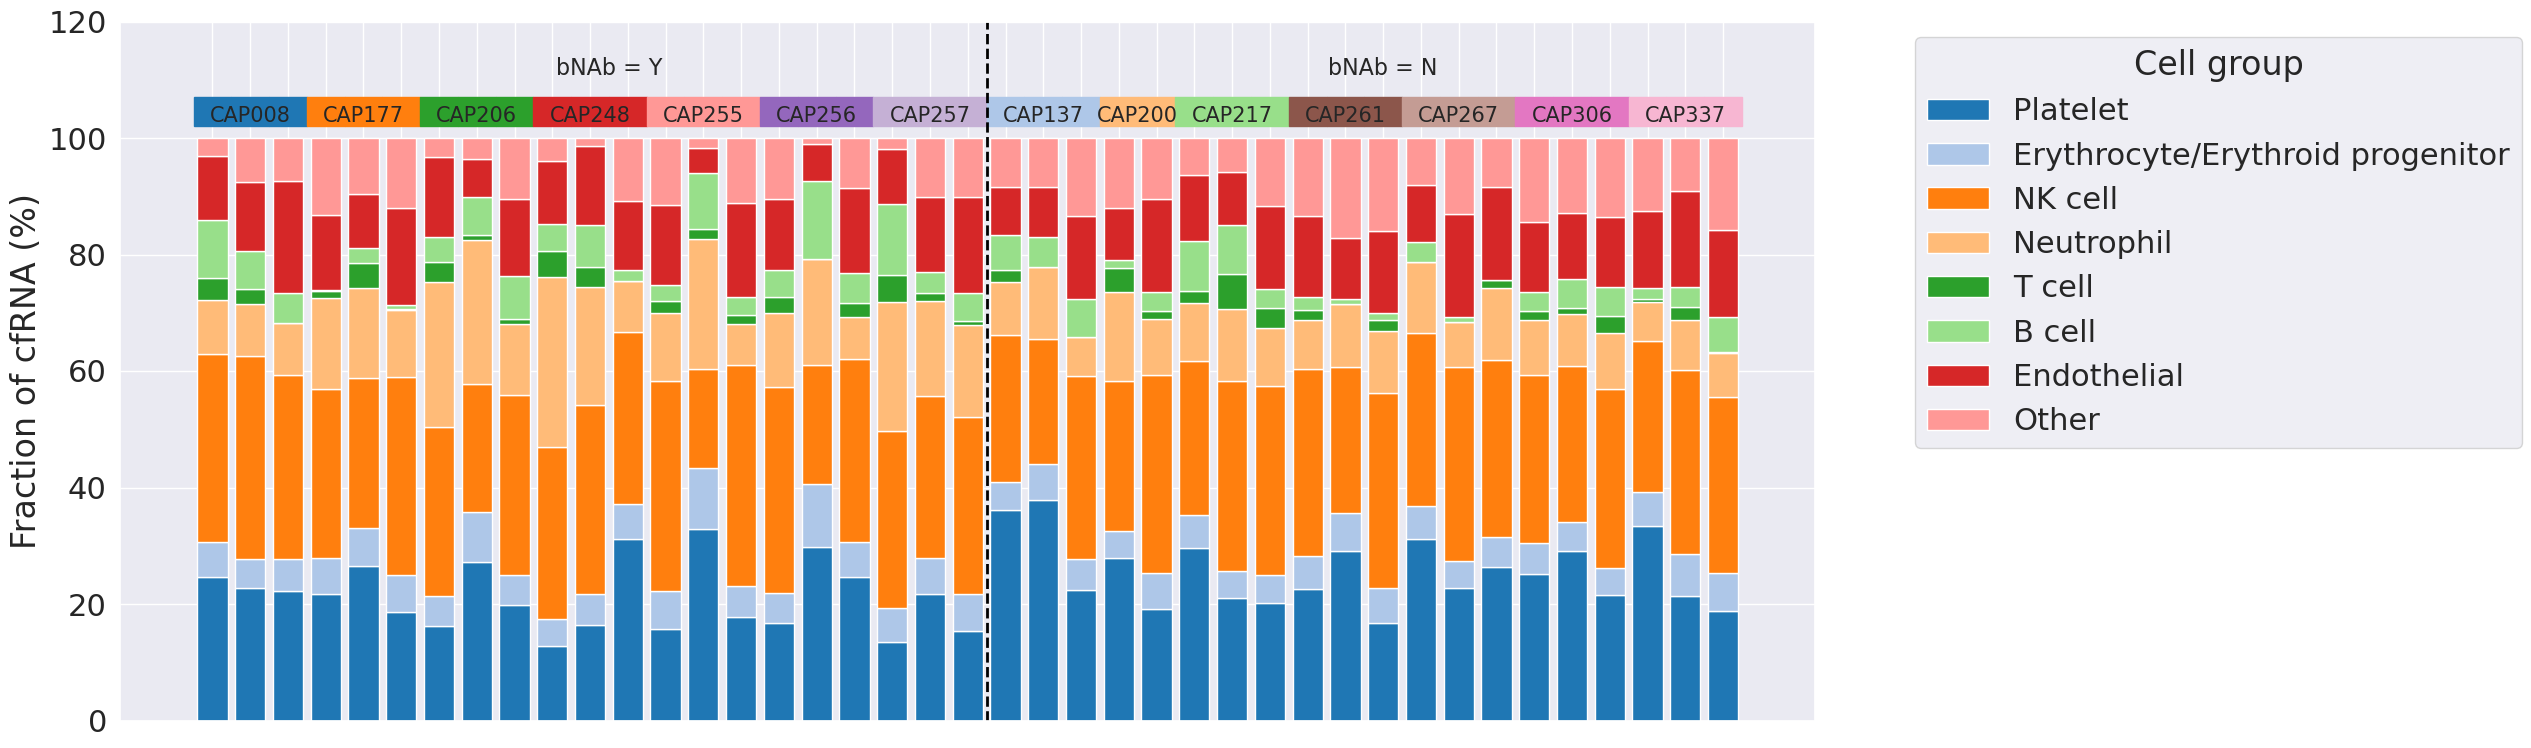

In [33]:
sns.set_theme(font_scale=2)
# Samples
samples = cell_mat_8.index.tolist()

# unique patients for the color palette
patient_ids_unique = sorted({patient_from_sample(s) for s in samples})
patient_palette = sns.color_palette("tab20", n_colors=len(patient_ids_unique))
patient_colors = dict(zip(patient_ids_unique, patient_palette))

color_bar = [patient_colors[patient_from_sample(s)] for s in samples]

# Blocks of samples per patient
blocks = []
current_patient = patient_from_sample(samples[0])
start = 0

for i, s in enumerate(samples[1:], start=1):
    p = patient_from_sample(s)
    if p != current_patient:
        blocks.append((current_patient, start, i - 1))
        current_patient = p
        start = i

blocks.append((current_patient, start, len(samples) - 1))

# Barplot
fig, ax = plt.subplots(figsize=(26, 8))

groups = cell_mat_8.columns
palette = sns.color_palette("tab20", n_colors=len(groups))
color_map = dict(zip(groups, palette))

x = np.arange(len(cell_mat_8))
bottom = np.zeros(len(cell_mat_8))

for g in groups:
    ax.bar(
        x,
        cell_mat_8[g].values,
        bottom=bottom,
        label=g,
        color=color_map[g]
    )
    bottom += cell_mat_8[g].values

ax.set_xticks(x)
ax.set_xticklabels([''] * len(x))
ax.set_ylabel("Fraction of cfRNA (%)")
#ax.set_title("Broad cfRNA composition", x=0.5, y=1.08)

# bNAb split 
split = len(bnab_yes_plot)
ax.axvline(split - 0.5, linestyle="--", color="black", linewidth=2)
ax.text(split / 2, 110, "bNAb = Y", ha="center", va="bottom", fontsize=16)
ax.text(split + len(bnab_no_plot) / 2, 110, "bNAb = N", ha="center", va="bottom", fontsize=16)


colorbar_y = 102

# Small colored rectangles for each sample
for i, color in enumerate(color_bar):
    ax.add_patch(plt.Rectangle(
        (i - 0.5, colorbar_y), 
        1.0,                   
        5.0,                    
        color=color,
        transform=ax.transData,
        clip_on=False
    ))

# Öabel 
for patient, start, end in blocks:
    center = (start + end) / 2.0
    ax.text(
        center,
        colorbar_y ,
        patient,
        ha="center",
        va="bottom",
        fontsize=15,
        rotation=0
    )

ax.set_ylim(0, 120)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Cell group")

plt.tight_layout()
os.makedirs('../figures/sfigures/sfigure4/panel_A/',exist_ok=True)
fig.savefig("../figures/sfigures/sfigure4/panel_A/sfig_deconvolution_barplot.svg", dpi=300, bbox_inches="tight")
plt.show()


## Panel B - Mann-Whitney U

In [34]:
id_col = cell_mat_8.index.name or "index" 
tmp = cell_mat_8.reset_index()
tmp.head(2)

,sample_id,Platelet,Erythrocyte/Erythroid progenitor,NK cell,Neutrophil,T cell,B cell,Endothelial,Other
0,SAMPLE_100008_1,24.576614,6.081061,32.263778,9.266888,3.718786,10.057965,11.009418,3.025490
1,SAMPLE_100008_2,22.824211,4.869137,34.942115,8.930937,2.582297,6.464124,11.761647,7.625531


In [35]:
# Create long df with fraction and cell_group
df_long = (
    tmp
    .melt(id_vars=id_col, var_name="cell_group", value_name="fraction")
    .rename(columns={id_col: "sample_id"})
)
df_long.head(4)

,sample_id,cell_group,fraction
0,SAMPLE_100008_1,Platelet,24.576614
1,SAMPLE_100008_2,Platelet,22.824211
2,SAMPLE_100008_3,Platelet,22.210945
3,SAMPLE_100177_1,Platelet,21.726500


In [36]:
# Add bnAb status for the samples
df_long = df_long.merge(
    design[["bNAbs"]],
    left_on="sample_id",
    right_index=True,
    how="left"
)
# Making sure the same categories as in cell_mat_8
df_long["cell_group"] = pd.Categorical(
    df_long["cell_group"],
    categories=cell_mat_8.columns,
    ordered=True
)
df_long.head(4)

,sample_id,cell_group,fraction,bNAbs
0,SAMPLE_100008_1,Platelet,24.576614,Y
1,SAMPLE_100008_2,Platelet,22.824211,Y
2,SAMPLE_100008_3,Platelet,22.210945,Y
3,SAMPLE_100177_1,Platelet,21.726500,Y


In [37]:
# Mann–Whitney tests per cell group

results = []
for g in cell_mat_8.columns: 
    sub = df_long[df_long["cell_group"] == g]
    y_vals = sub.loc[sub["bNAbs"] == "Y", "fraction"].dropna()
    n_vals = sub.loc[sub["bNAbs"] == "N", "fraction"].dropna()
    
    if len(y_vals) > 0 and len(n_vals) > 0:
        # Two-sided Mann-Whitney test between the bnAb groups
        stat, p = mannwhitneyu(y_vals, n_vals, alternative="two-sided")
    else:
        stat, p = np.nan, np.nan
    
    results.append({
        "cell_group": g,
        "U_stat": stat,
        "p_value": p,
        "n_Y": len(y_vals),
        "n_N": len(n_vals),
    })

res_df = pd.DataFrame(results)
res_df

,cell_group,U_stat,p_value,n_Y,n_N
0,Platelet,130.0,0.038124,21,20
1,Erythrocyte/Erythroid progenitor,273.0,0.103075,21,20
2,NK cell,234.0,0.539924,21,20
3,Neutrophil,314.0,0.006945,21,20
4,T cell,243.0,0.395469,21,20
5,B cell,270.0,0.120691,21,20
6,Endothelial,200.0,0.804305,21,20
7,Other,94.0,0.002591,21,20


In [38]:
# Multiple testing correction (Bonferroni)

mask_valid = res_df["p_value"].notna()
pvals = res_df.loc[mask_valid, "p_value"].values

if len(pvals) > 0:
    reject, p_adj, _, _ = multipletests(pvals, method="fdr_bh")
    res_df.loc[mask_valid, "p_adj"] = p_adj
    
    res_df.loc[mask_valid, "significant_FDR_0.05"] = reject
else:
    res_df["p_adj"] = np.nan
    res_df["significant_FDR_0.05"] = False
res_df

,cell_group,U_stat,p_value,n_Y,n_N,p_adj,significant_FDR_0.05
0,Platelet,130.0,0.038124,21,20,0.101663,False
1,Erythrocyte/Erythroid progenitor,273.0,0.103075,21,20,0.193105,False
2,NK cell,234.0,0.539924,21,20,0.617056,False
3,Neutrophil,314.0,0.006945,21,20,0.027778,True
4,T cell,243.0,0.395469,21,20,0.527292,False
5,B cell,270.0,0.120691,21,20,0.193105,False
6,Endothelial,200.0,0.804305,21,20,0.804305,False
7,Other,94.0,0.002591,21,20,0.020730,True


In [39]:
print("\nMann–Whitney + BH/FDR results (sorted by p_adj):")
print(res_df.sort_values("p_adj"))


Mann–Whitney + BH/FDR results (sorted by p_adj):
                         cell_group  U_stat   p_value  n_Y  n_N     p_adj  \
7                             Other    94.0  0.002591   21   20  0.020730   
3                        Neutrophil   314.0  0.006945   21   20  0.027778   
0                          Platelet   130.0  0.038124   21   20  0.101663   
1  Erythrocyte/Erythroid progenitor   273.0  0.103075   21   20  0.193105   
5                            B cell   270.0  0.120691   21   20  0.193105   
4                            T cell   243.0  0.395469   21   20  0.527292   
2                           NK cell   234.0  0.539924   21   20  0.617056   
6                       Endothelial   200.0  0.804305   21   20  0.804305   

  significant_FDR_0.05  
7                 True  
3                 True  
0                False  
1                False  
5                False  
4                False  
2                False  
6                False  


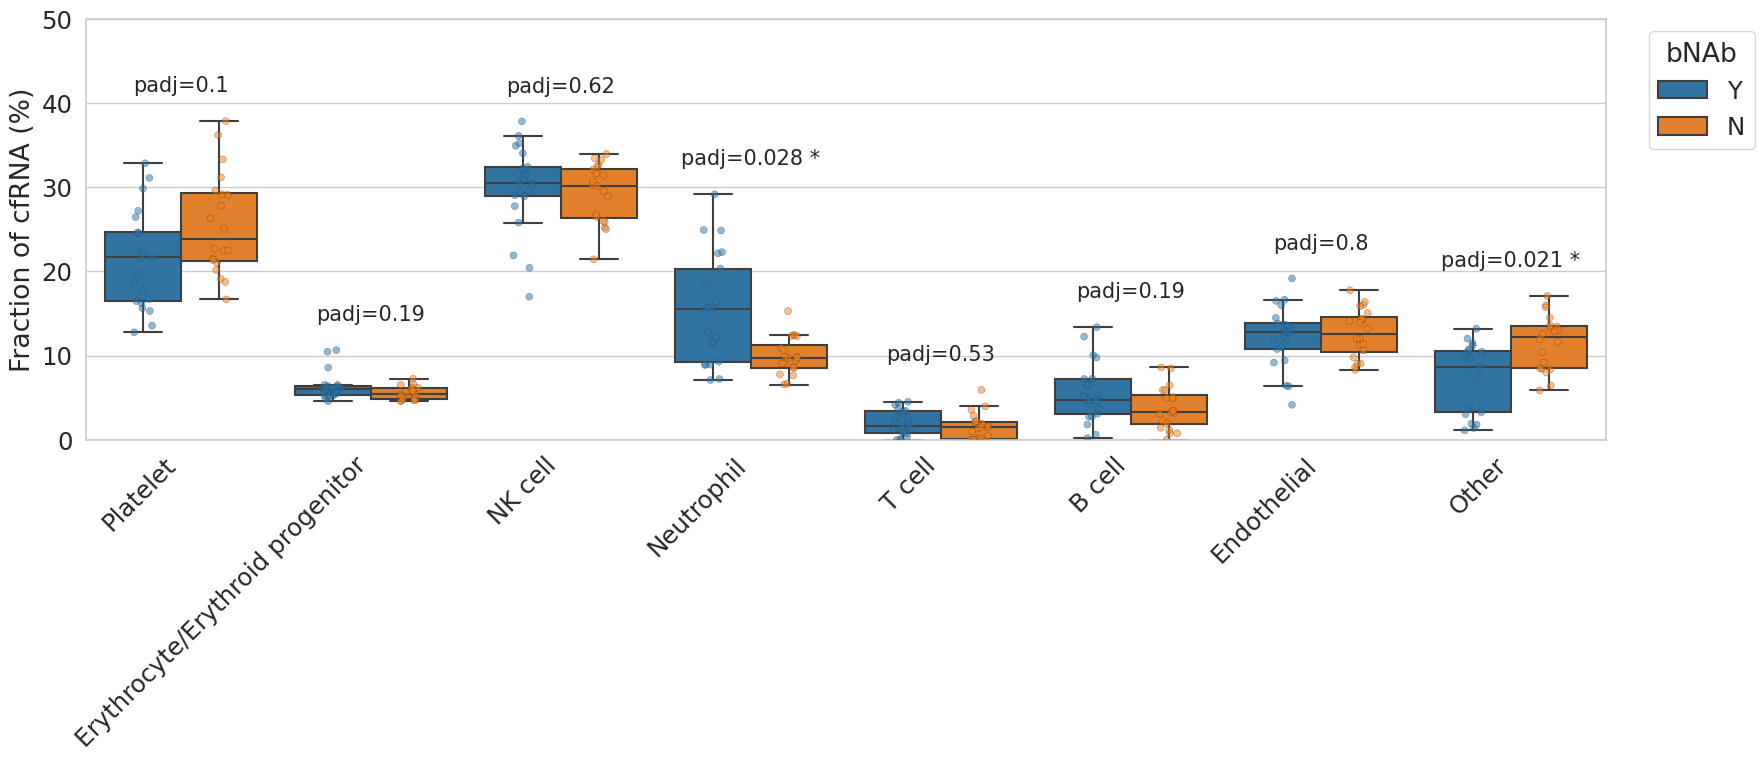

In [40]:
sns.set_theme(style="whitegrid", font_scale=1.6)

# map group to padj & significance for annotation
padj_map = res_df.set_index("cell_group")["p_adj"].to_dict()
sig_map  = res_df.set_index("cell_group")["significant_FDR_0.05"].to_dict()

# Boxplots for all cell groups

plt.figure(figsize=(18, 8))

# palette for yes or no
hue_palette = {"Y": "#1f77b4", "N": "#ff7f0e"}

ax = sns.boxplot(
    data=df_long,
    x="cell_group",
    y="fraction",
    hue="bNAbs",
    order=cell_mat_8.columns,
    showfliers=False,
    palette=hue_palette,
    linewidth=1.5
)

sns.stripplot(
    data=df_long,
    x="cell_group",
    y="fraction",
    hue="bNAbs",
    order=cell_mat_8.columns,
    dodge=True,
    alpha=0.5,
    linewidth=0.4,
    edgecolor="gray",
    palette=hue_palette
)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="bNAb", bbox_to_anchor=(1.02, 1), loc="upper left")

ax.set_ylabel("Fraction of cfRNA (%)")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
#ax.set_title("\nMann–Whitney + BH/FDR - cfRNA fractions per cell group\nbNAb vs non-bNAb", fontsize = 30,pad=20)
ax.set_ylim(0, 50)

# p_adj above each group
y_offset = 3  

for i, g in enumerate(cell_mat_8.columns):
    sub = df_long[df_long["cell_group"] == g]
    if sub.empty:
        continue
    y_max = sub["fraction"].max()
    y_pos = min(y_max + y_offset, ax.get_ylim()[1] - 1)

    padj = padj_map.get(g, np.nan)
    if pd.notna(padj):
        txt = f"padj={padj:.2g}"
        if sig_map.get(g, False):
            txt += " *"   # mark FDR-significant
    else:
        txt = "q=NA"

    ax.text(
        i, y_pos,
        txt,
        ha="center",
        va="bottom",
        fontsize=15,
        rotation=0
    )

plt.tight_layout()
os.makedirs('../figures/sfigures/sfigure4/panel_B/',exist_ok=True)
plt.savefig("../figures/sfigures/sfigure4/panel_B/sfig_deconvolution_mannwhitneyu.svg", dpi=300, bbox_inches="tight")
plt.show()




# Figure S5 - HIV genotypes, coverage and mutations

## Panel A - Coverage

In [42]:
hiv_coverage = pd.read_csv('../tables/hiv_coverage.csv', index_col = 0)

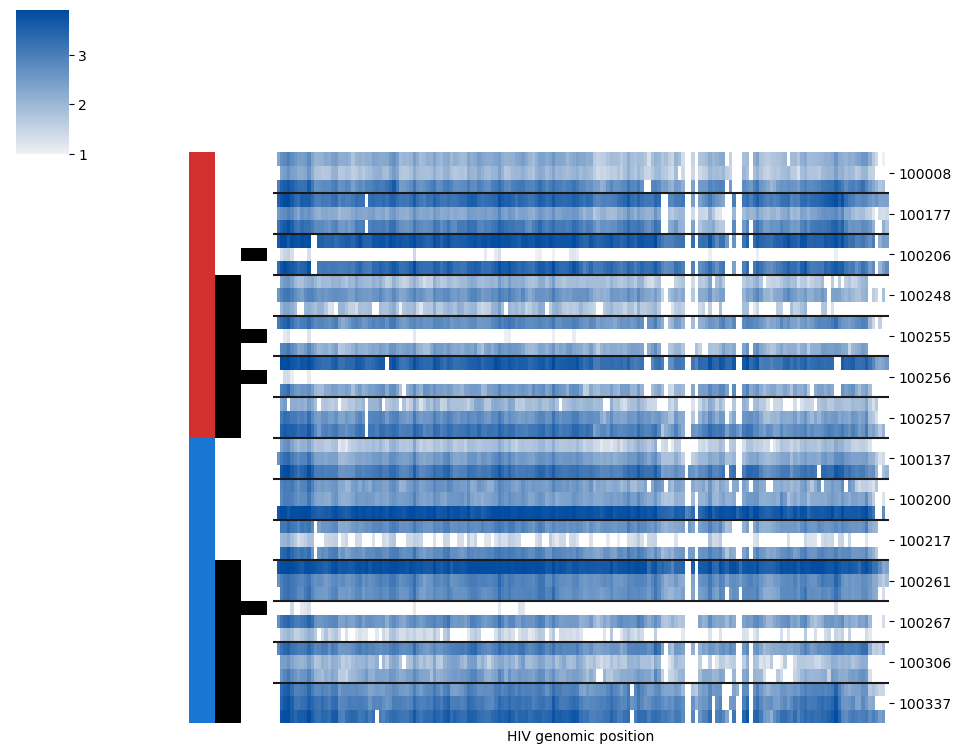

In [54]:
# Order of samples
a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

colors = [21*[red] + 21*[blue],
          9*["white"] + 12*["black"] + 9*["white"] + 12*["black"],
          ["black" if i in [7, 13, 16, 33] else "white" for i in range(42)]]

x = np.log10(hiv_coverage.T.loc[c]+1)
x = x.T
x["row"] = [i // 50 for i in x.index]
x = x.groupby("row").mean().T

mask = hiv_coverage.T.loc[c].T < 8
mask["row"] = [i // 50 for i in mask.index]
mask = mask.groupby("row").mean().T > 0

g = sns.clustermap(x, cmap=sns.light_palette(dark_blue, as_cmap=True),
           row_cluster=False, col_cluster=False, figsize=(42/4, 8),
           row_colors=colors, mask=mask)

g.ax_heatmap.set_yticks([i*3+1.5 for i in range(14)])
g.ax_heatmap.set_yticklabels(breadth_metadata.loc[c]["Patient"].unique())
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('HIV genomic position')
g.ax_heatmap.set_xticks([])

for i in range(1,14):
    g.ax_heatmap.axhline(i*3, color='k')


os.makedirs('../figures/sfigures/sfigure5/panel_A/',exist_ok=True)
g.savefig("../figures/sfigures/sfigure5/panel_A/coverage_heatmap.svg", dpi=300, bbox_inches="tight")

## Panel B - Counts

In [44]:
import pickle
with open('../tables/hiv_counts.txt', 'rb') as fp:
    hiv_counts = pickle.load(fp)

In [48]:
pd.Series(hiv_counts)

SAMPLE_100008_1      24243
SAMPLE_100008_2      15250
SAMPLE_100008_3     145574
SAMPLE_100137_1      11538
SAMPLE_100137_2      53694
SAMPLE_100137_3     254227
SAMPLE_100177_1     334528
SAMPLE_100177_2      37201
SAMPLE_100177_3     158078
SAMPLE_100200_1      47061
SAMPLE_100200_2      47928
SAMPLE_100200_3    1193064
SAMPLE_100206_1    1017890
SAMPLE_100206_2        908
SAMPLE_100206_3     364911
SAMPLE_100217_1      84875
SAMPLE_100217_2       2867
SAMPLE_100217_3     106600
SAMPLE_100248_1      14794
SAMPLE_100248_2      65098
SAMPLE_100248_3      10329
SAMPLE_100255_1      99704
SAMPLE_100255_2        552
SAMPLE_100255_3      36116
SAMPLE_100256_1     611134
SAMPLE_100256_2        394
SAMPLE_100256_3      52649
SAMPLE_100257_1      13810
SAMPLE_100257_2      80263
SAMPLE_100257_3     208587
SAMPLE_100261_1    1467030
SAMPLE_100261_2     115083
SAMPLE_100261_3      98507
SAMPLE_100267_1        696
SAMPLE_100267_2      73142
SAMPLE_100267_3       3878
SAMPLE_100306_1     123154
S

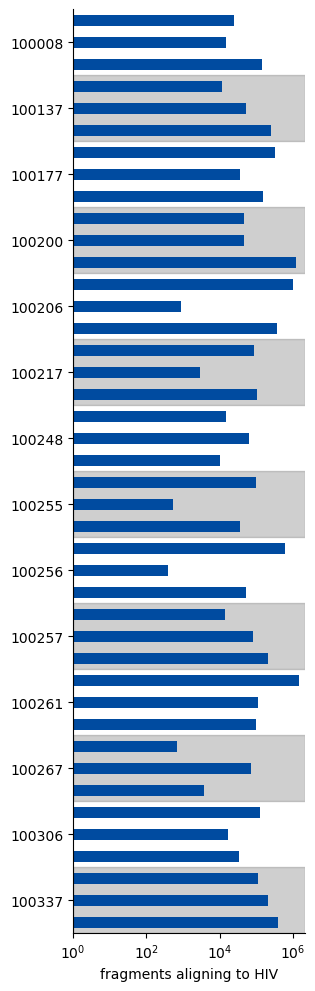

In [55]:
sns.reset_orig()
plt.figure(figsize=(3, 12))
pd.Series(hiv_counts).plot.barh(color=dark_blue)
plt.xscale("log")
plt.xlim(1, plt.xlim()[1])
sns.despine()
plt.xlabel("fragments aligning to HIV")

for i in range(14):
    if (i % 2) == 1:
        plt.axhspan(ymin=i*3-0.5, ymax=(i+1)*3-0.5, zorder=0, color=grey, alpha=0.3)

# if the other figure is the reverse order, do this:
plt.gca().invert_yaxis()
plt.yticks(np.arange(14)*3+1, meta1["PID"].unique())


os.makedirs('../figures/sfigures/sfigure5/panel_B/',exist_ok=True)
plt.savefig("../figures/sfigures/sfigure5/panel_B/HIV_counts.svg", dpi=300, bbox_inches="tight")
plt.show()


## Panel C - Tree

## Panel D - SNVs

In [49]:
import pickle
with open('../tables/sample_consenses.csv', 'rb') as fp:
    sample_consenses = pickle.load(fp)


In [ ]:

with open('../tables/pileups.txt', 'rb') as fp:
    pileups = pickle.load(fp)

In [51]:

with open('../tables/entropies.txt', 'rb') as fp:
    entropies = pickle.load(fp)


In [56]:
def different_SNVs(i, j):
    """ Finds locations of different SNVs """
    x = sample_consenses.loc[[i, j], sample_consenses.loc[i] != sample_consenses.loc[j]]
    return x.replace(".", np.nan).dropna(axis=1).columns

def plot_sample_SNVs(s, snvs=[]):
    figsize(15, 2)
    x = pileups[s].reindex(sample_consenses.columns)
    x[x.sum(axis=1) == 0] = np.nan # Make sure zeros are nan so I don't plot these points
    x.dropna(inplace=True)
    x = x.div(x.sum(axis=1), axis=0).reindex(snvs)
    x.plot.bar(stacked=True, color=[blue, red, green, yellow], width=0.8)
    sns.despine()
    plt.xticks([])
    plt.legend(loc=(1, 0))
    plt.title(s)
    plt.show()
    
def plot_HIV_snvs(y, s, SNVs):
    ax = plt.gca()
    colors = []
    for l in SNVs:
        if sample_consenses.loc[s, l] == "G":
            color=green
        elif sample_consenses.loc[s, l] == "T":
            color=yellow
        elif sample_consenses.loc[s, l] == "C":
            color=red
        elif sample_consenses.loc[s, l] == "A":
            color=blue
        else:
            color=grey
        colors.append(color)
    ax.scatter(SNVs, [y]*len(SNVs), marker="|", color=colors)

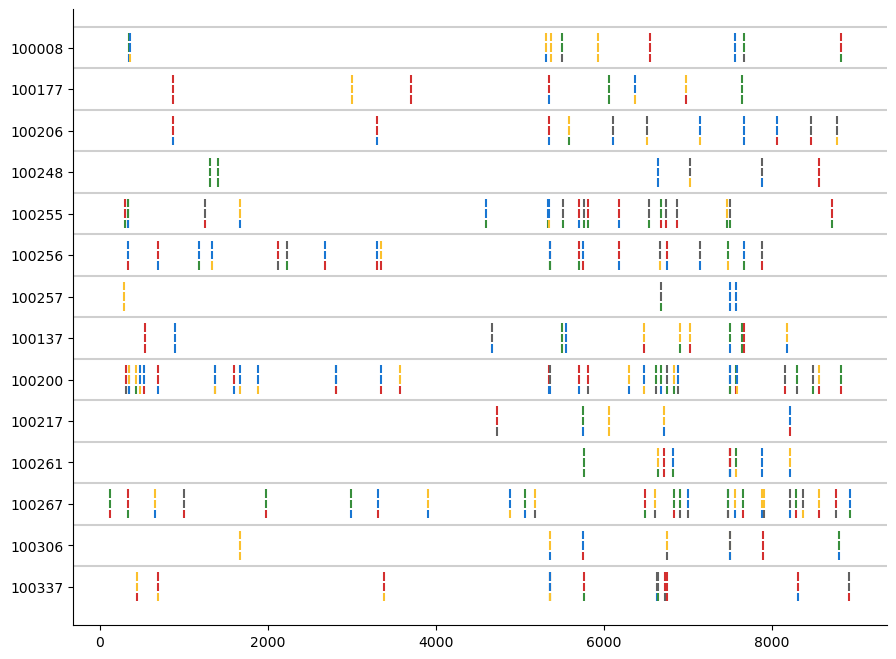

In [60]:
figsize(42/4, 8)
n = 0
ylocs, ylabels = [], []

a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

for p in meta1.loc[c]["PID"].unique()[::-1]:
    g = meta1.loc[sample_consenses.index][meta1.loc[sample_consenses.index, "PID"] == p]
    if len(g) == 2:
        i, j = g.index
        d = different_SNVs(i, j)
        plot_HIV_snvs(n, i, d)
        plot_HIV_snvs(n+1, j, d)
        plt.axhline(y=n+2, color=grey, alpha=0.3)
        ylocs.append((2*n+3)/2-1)
        ylabels.append(p)
        n += 3
    else:
        i, j, k = g.index
        d1 = different_SNVs(i, j)
        d2 = different_SNVs(i, k)
        d3 = different_SNVs(j, k)
        d = d1.union(d2).union(d3)
        plot_HIV_snvs(n, i, d)
        plot_HIV_snvs(n+1, j, d)
        plot_HIV_snvs(n+2, j, d)
        plt.axhline(y=n+3, color=grey, alpha=0.3)
        ylocs.append((2*n+4)/2-1)
        ylabels.append(p)
        n += 4

#plt.xlim(0, 9035)
plt.yticks(ylocs, ylabels)
sns.despine()

os.makedirs('../figures/sfigures/sfigure5/panel_D/',exist_ok=True)
plt.savefig("../figures/sfigures/sfigure5/panel_D/HIV_SNV_positions.svg", dpi=300, bbox_inches="tight")

## Panel E

In [61]:
a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [62]:
from collections.abc import Sized
def mutation_rate(start, end, mutations, unit="months"):
    # ensure pandas Timestamps
    start = pd.to_datetime(start)
    end   = pd.to_datetime(end)

    # duration in days
    delta_days = (end - start) / np.timedelta64(1, "D")

    # convert to requested unit
    if unit == "months":
        duration = delta_days / 30.4375        # average days/month
    elif unit == "years":
        duration = delta_days / 365.25
    elif unit == "weeks":
        duration = delta_days / 7.0
    elif unit == "days":
        duration = delta_days
    else:
        raise ValueError("unit must be one of: 'months', 'years', 'weeks', 'days'")

    # count mutations 
    try:
        # if it's boolean-like
        if getattr(mutations, "dtype", None) == bool or (
            hasattr(mutations, "dtype") and str(mutations.dtype) == "bool"
        ):
            n = int(np.count_nonzero(mutations))
        else:
            n = len(mutations) if isinstance(mutations, Sized) else int(mutations)
    except Exception:
        n = int(np.count_nonzero(mutations))

    return duration, n

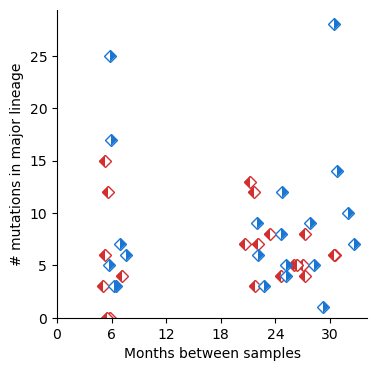

In [63]:
TM = []
figsize(4, 4)
for p in meta1.loc[c]["PID"].unique():
    g = meta1.loc[sample_consenses.index][meta1.loc[sample_consenses.index, "PID"] == p]
    if design.loc[g.index[0], "bNAbs"] == "Y":
        color=red
        fillstyle="left"
    else:
        color=blue
        fillstyle="right"
    if len(g) == 2:
        i, j = g.index
        d = different_SNVs(i, j)
        t1, t2 = meta1.loc[i]["vdate"], meta1.loc[j]["vdate"]
        plt.plot(*mutation_rate(t1, t2, d), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle=fillstyle)
        plt.plot(*mutation_rate(t1, t2, d), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
        TM.append(mutation_rate(t1, t2, d))
    else:
        i, j, k = g.index
        d1 = different_SNVs(i, j)
        d2 = different_SNVs(i, k)
        d3 = different_SNVs(j, k)
        #d = d1 | d2 | d3
        d = pd.Index(d1).union(d2).union(d3)
        t1, t2, t3 = meta1.loc[i]["vdate"], meta1.loc[j]["vdate"], meta1.loc[k]["vdate"]
        # t1, t2
        plt.plot(*mutation_rate(t1, t2, d1), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle=fillstyle)
        plt.plot(*mutation_rate(t1, t2, d1), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
        TM.append(mutation_rate(t1, t2, d1))
        # t1, t3
        plt.plot(*mutation_rate(t1, t3, d2), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle=fillstyle)
        plt.plot(*mutation_rate(t1, t3, d2), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
        TM.append(mutation_rate(t1, t3, d2))
        # t2, t3
        plt.plot(*mutation_rate(t2, t3, d3), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle=fillstyle)
        plt.plot(*mutation_rate(t2, t3, d3), color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
        TM.append(mutation_rate(t2, t3, d3))
    
plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1])
plt.xticks([0, 6, 12, 18, 24, 30])
plt.xlabel("Months between samples")
plt.ylabel("# mutations in major lineage")
sns.despine()

os.makedirs('../figures/sfigures/sfigure5/panel_E/',exist_ok=True)
plt.savefig("../figures/sfigures/sfigure5/panel_E/HIV_mutation_rate.svg", dpi=300, bbox_inches="tight")
plt.show()

## Transcriptome

In [64]:
genes = pd.read_table("../tables/gene_counts.txt", index_col=0).T

genes_duprm = genes.copy().loc[[s for s in genes.index if "duprm" in s]]
genes_duprm["sample"] = [s.split(".")[0] for s in genes_duprm.index]
genes_duprm = genes_duprm.groupby("sample").sum().T

genes = genes.copy().loc[[s for s in genes.index if "duprm" not in s]]
genes["sample"] = [s.split(".")[0] for s in genes.index]
genes = genes.groupby("sample").sum().T

In [65]:
just_genes = genes.iloc[:-5]
just_genes = genes.loc[[g for g in genes.index if "ENSG" in g]]
cpm = (1e6*just_genes.div(just_genes.sum()))
logCPM = np.log10(cpm+1)

X = logCPM.loc[:, meta1.index.difference(["SAMPLE_100200_1"])].T

# S6 - Fragment length and coverage of cfHIV reads

In [66]:
import pickle

with open("../tables/CON_C_fragments.pkl", "rb") as f:
    data = pickle.load(f)

frag_starts = data["frag_starts"]
frag_spans  = data["frag_spans"]
ref_len     = data["ref_len"]
ref         = data["ref"]

print(f"Loaded {len(frag_spans):,} fragments from pickle")

Loaded 464,039 fragments from pickle


## Panel A

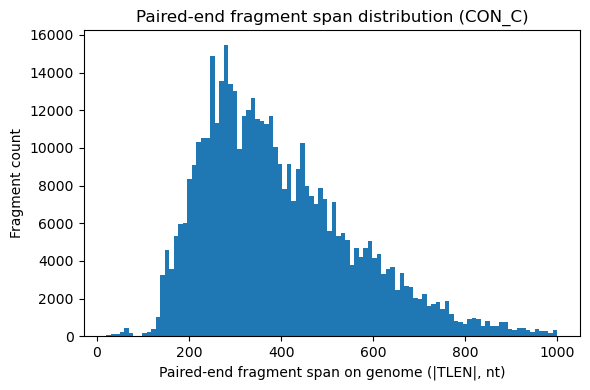

In [67]:
sns.reset_orig()

# fragment fistribution
plt.figure(figsize=(6,4))
plt.hist(frag_spans, bins=100)
plt.xlabel("Paired-end fragment span on genome (|TLEN|, nt)")
plt.ylabel("Fragment count")
plt.title("Paired-end fragment span distribution (CON_C)")
plt.tight_layout()
os.makedirs('../figures/sfigures/sfigure6/panel_A', exist_ok=True)
plt.savefig("../figures/sfigures/sfigure6/panel_A/fig_length_distribution.svg", dpi=300, bbox_inches="tight")
plt.show()


## Panel B

,bin,mean,median,count,p25,p75,bin_mid
0,"[0.0, 903.4)",355.298943,316.0,54231,245.0,450.0,451.7
1,"[903.4, 1806.8)",410.872984,382.0,58166,297.0,511.0,1355.1
2,"[1806.8, 2710.2)",409.749157,351.0,61066,273.0,522.0,2258.5
3,"[2710.2, 3613.6)",421.720420,393.0,82785,291.0,530.0,3161.9
4,"[3613.6, 4517.0)",364.989833,342.0,49377,266.0,447.0,4065.3
5,"[4517.0, 5420.4)",400.181222,384.0,42219,292.0,481.0,4968.7
6,"[5420.4, 6323.8)",393.616639,359.0,24473,268.0,488.0,5872.1
7,"[6323.8, 7227.2)",377.103549,339.0,27166,248.0,470.0,6775.5
8,"[7227.2, 8130.6)",409.465614,383.0,52812,279.0,508.0,7678.9
9,"[8130.6, 9034.0)",338.148161,321.0,11744,254.0,426.0,8582.3


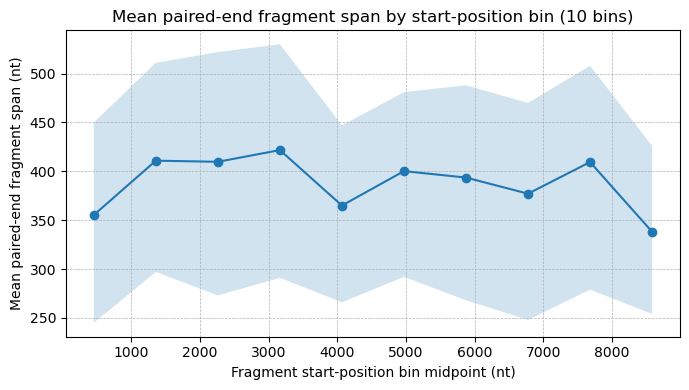

In [68]:
n_bins = 10
# Bin by 10 bins
edges = np.linspace(0, ref_len, n_bins+1)
df = pd.DataFrame({"frag_start": frag_starts, "frag_span": frag_spans})
df["bin"] = pd.cut(df["frag_start"], bins=edges, include_lowest=True, right=False)

summary = df.groupby("bin")["frag_span"].agg(
    mean="mean",
    median="median",
    count="count",
    p25=lambda x: np.percentile(x, 25),
    p75=lambda x: np.percentile(x, 75),
).reset_index()

summary["bin_mid"] = (edges[:-1] + edges[1:]) / 2
display(summary)

plt.figure(figsize=(7,4))
plt.plot(summary["bin_mid"], summary["mean"], marker="o")
plt.fill_between(summary["bin_mid"], summary["p25"], summary["p75"], alpha=0.2)
plt.xlabel("Fragment start-position bin midpoint (nt)")
plt.ylabel("Mean paired-end fragment span (nt)")
plt.title("Mean paired-end fragment span by start-position bin (10 bins)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
os.makedirs('../figures/sfigures/sfigure6/panel_B', exist_ok=True)
plt.savefig("../figures/sfigures/sfigure6/panel_B/fig_length_distribution_mean.svg", dpi=300, bbox_inches="tight")
plt.show()

## Panel D

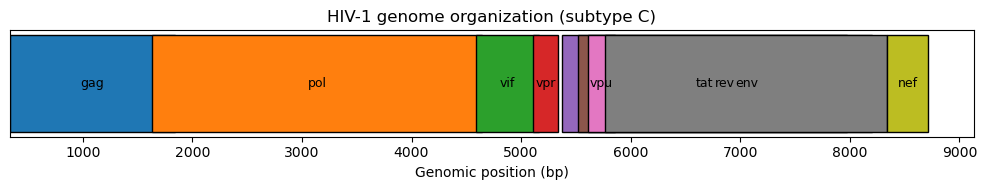

In [69]:
from Bio import SeqIO

record = SeqIO.read("../tables/sequence.gb", "genbank")

fig, ax = plt.subplots(figsize=(10, 2))

y = 0
height = 0.6

for feature in record.features:
    if feature.type == "CDS":
        start = int(feature.location.start)
        end = int(feature.location.end)
        gene = feature.qualifiers.get("gene", [""])[0]

        ax.barh(
            y,
            end - start,
            left=start,
            height=height,
            edgecolor="black",
            label=gene
        )
        ax.text((start + end) / 2, y, gene, ha="center", va="center", fontsize=9)

ax.set_xlabel("Genomic position (bp)")
ax.set_yticks([])
ax.set_title("HIV-1 genome organization (subtype C)")
plt.tight_layout()
os.makedirs('../figures/sfigures/sfigure6/panel_D', exist_ok=True)
plt.savefig("../figures/sfigures/sfigure6/panel_D/fig_hiv_ncbi_gene_map.svg", dpi=300, bbox_inches="tight")
plt.show()

# S7 - Subsampling analysis of HIV genome coverage from cfRNA

In [70]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [71]:

# computed table
df = pd.read_csv("../tables/cap261_downsample_coverage_stats.tsv", sep="\t")

# Sort by mapped reads
df = df.sort_values("mapped_reads").reset_index(drop=True)


In [72]:
# Common colormap scaling for "downsampling level"
norm = mcolors.LogNorm(vmin=df["mapped_reads"].min(),
                       vmax=df["mapped_reads"].max())
cmap = cm.Set2

## Panel A - Breadth vs reads

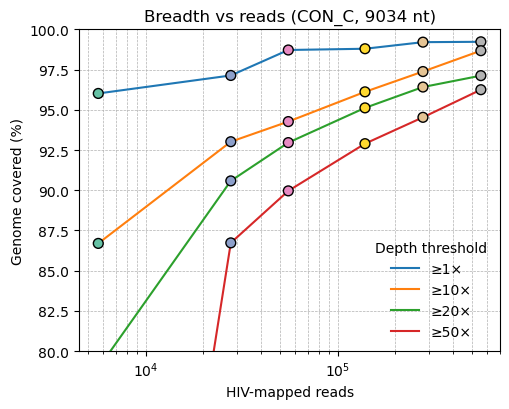

In [73]:

figA, axA = plt.subplots(figsize=(5.2, 4.2))

for col, lab in [
    ("pct_ge_1x","≥1×"),
    ("pct_ge_10x","≥10×"),
    ("pct_ge_20x","≥20×"),
    ("pct_ge_50x","≥50×")
]:
    axA.plot(df["mapped_reads"], df[col], linewidth=1.5, label=lab)
    axA.scatter(
        df["mapped_reads"], df[col],
        c=df["mapped_reads"], cmap=cmap, norm=norm,
        edgecolor="black", s=50, zorder=3
    )

axA.set_xscale("log")
axA.set_ylim(80, 100)
axA.set_xlabel("HIV-mapped reads")
axA.set_ylabel("Genome covered (%)")
axA.set_title("Breadth vs reads (CON_C, 9034 nt)")
axA.grid(True, which="both", linestyle="--", linewidth=0.5)
axA.legend(frameon=False, loc="lower right", title="Depth threshold")

figA.tight_layout()
os.makedirs('../figures/sfigures/sfigure7/panel_A', exist_ok=True)
figA.savefig("../figures/sfigures/sfigure7/panel_A/fig_downsampling_A_breadth.svg", dpi=300, bbox_inches="tight")



## Panel B - Mean depth vs reads

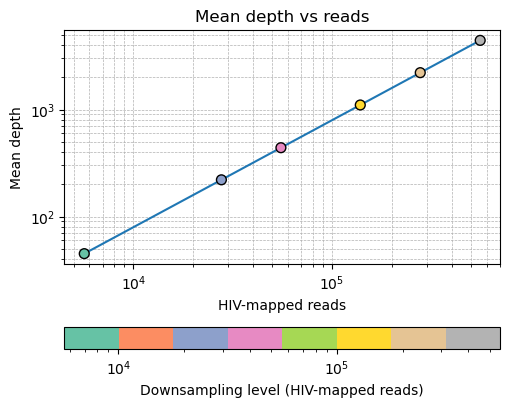

In [74]:
figB, axB = plt.subplots(figsize=(5.2, 4.2))

axB.plot(df["mapped_reads"], df["mean_depth"], linewidth=1.5)

scB = axB.scatter(
    df["mapped_reads"], df["mean_depth"],
    c=df["mapped_reads"], cmap=cmap, norm=norm,
    edgecolor="black", s=50, zorder=3
)

axB.set_xscale("log")
axB.set_yscale("log")
axB.set_xlabel("HIV-mapped reads")
axB.set_ylabel("Mean depth")
axB.set_title("Mean depth vs reads")
axB.grid(True, which="both", linestyle="--", linewidth=0.5)

cbar = figB.colorbar(scB, ax=axB, orientation="horizontal", pad=0.18)
cbar.set_label("Downsampling level (HIV-mapped reads)")

figB.tight_layout()
os.makedirs('../figures/sfigures/sfigure7/panel_B', exist_ok=True)
figB.savefig("../figures/sfigures/sfigure7/panel_B/fig_downsampling_B_mean_depth.svg", dpi=300, bbox_inches="tight")


## Panel C 

In [75]:

# computed table
df = pd.read_csv("../tables/downsample_coverage_stats_all.tsv", sep="\t")

# Sort by mapped reads
df = df.sort_values("mapped_reads").reset_index(drop=True)



In [76]:
df = df[~(df['sample'].str.contains('NTC') | df['sample'].str.contains('water'))].copy()

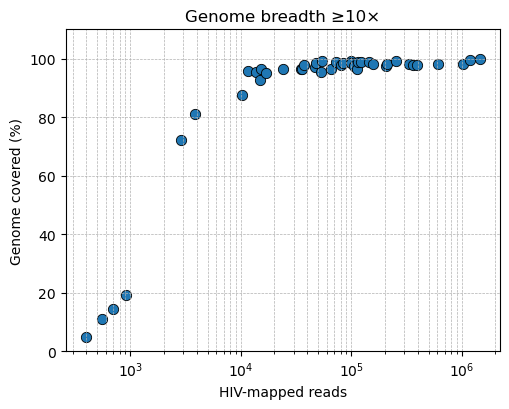

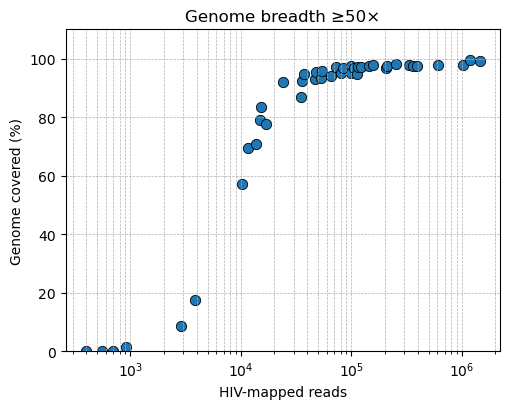

In [77]:

thresholds = [

    ("pct_ge_10x", "≥10×"),

    ("pct_ge_50x", "≥50×"),
]
os.makedirs('../figures/sfigures/sfigure7/panel_C', exist_ok=True)
for col, lab in thresholds:
    
    fig, ax = plt.subplots(figsize=(5.2, 4.2))
    
    ax.scatter(
        df["mapped_reads"], df[col],
        s=55,
        color="#1f77b4",     # all blue
        edgecolor="black",
        linewidth=0.6
    )
    
    ax.set_xscale("log")
    ax.set_ylim(0, 110)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    ax.set_title(f"Genome breadth {lab}")
    ax.set_xlabel("HIV-mapped reads")
    ax.set_ylabel("Genome covered (%)")
    
    fig.tight_layout()
    
    fig.savefig("../figures/sfigures/sfigure7/panel_C/fig_breadth_{col}.svg", dpi=300, bbox_inches="tight")
    
plt.show()

# Figure S8 - Correlations of genes with different disease measurements

In [78]:
# Load gene names and HIV associated genes
ensembl = pd.read_table("../tables/ensembl.tsv", index_col=0)
ensembl_clean = ensembl[ensembl["Gene name"].apply(lambda s: len(s.split("-"))) == 1]

hiv_genes = pd.read_excel("../tables/MalaCards-HIV.xlsx", index_col=0)
hiv_genes["gene"] = hiv_genes["Symbol"].apply(lambda s: s.split()[0])
hiv_genes.index = hiv_genes["gene"]
hiv_ensembl = [g for g in ensembl.index if ensembl.loc[g, "Gene name"] in hiv_genes["gene"].values]

In [79]:
clin_gene_corr = pd.read_table("../tables/clinicalmeasurements_gene_correlations.txt", index_col=0)

## Panel A

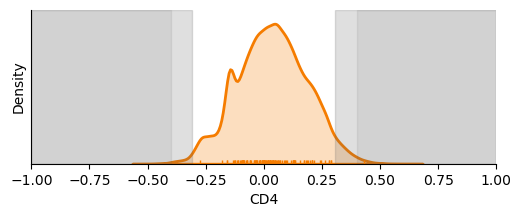

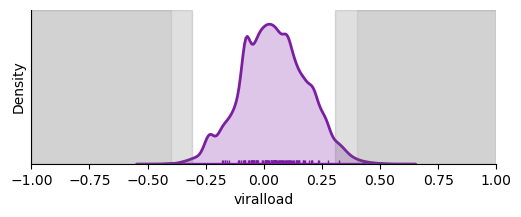

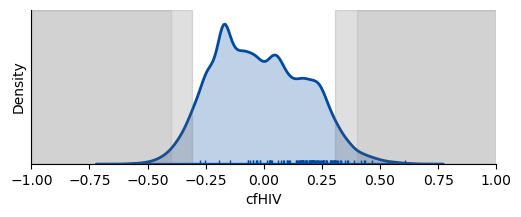

In [80]:
os.makedirs('../figures/sfigures/sfigure8/panel_A', exist_ok=True)

figsize(6, 2)
sns.kdeplot(clin_gene_corr["CD4"].dropna(), shade=True, color=orange, linewidth=2, legend=False)
sns.rugplot(clin_gene_corr["CD4"].reindex(hiv_ensembl).dropna(), color=orange)
plt.axvspan(xmin=-1, xmax=-0.307, color=grey, alpha=0.2)
plt.axvspan(xmin=-1, xmax=-0.4, color=grey, alpha=0.1)
plt.axvspan(xmin=0.307, xmax=1, color=grey, alpha=0.2)
plt.axvspan(xmin=0.4, xmax=1, color=grey, alpha=0.1)
plt.yticks([])
plt.xlim(-1, 1)
sns.despine()
plt.savefig("../figures/sfigures/sfigure8/panel_A/correlation_CD4.svg")
plt.show()

sns.kdeplot(clin_gene_corr["viralload"].dropna(), shade=True, color=purple, linewidth=2, legend=False)
sns.rugplot(clin_gene_corr["viralload"].reindex(hiv_ensembl).dropna(), color=purple)
plt.axvspan(xmin=-1, xmax=-0.307, color=grey, alpha=0.2)
plt.axvspan(xmin=-1, xmax=-0.4, color=grey, alpha=0.1)
plt.axvspan(xmin=0.307, xmax=1, color=grey, alpha=0.2)
plt.axvspan(xmin=0.4, xmax=1, color=grey, alpha=0.1)
plt.yticks([])
plt.xlim(-1, 1)
sns.despine()
plt.savefig("../figures/sfigures/sfigure8/panel_A/correlation_viralload.svg")
plt.show()

sns.kdeplot(clin_gene_corr["cfHIV"].dropna(), shade=True, color=dark_blue, linewidth=2, legend=False)
sns.rugplot(clin_gene_corr["cfHIV"].reindex(hiv_ensembl).dropna(), color=dark_blue)
plt.axvspan(xmin=-1, xmax=-0.307, color=grey, alpha=0.2)
plt.axvspan(xmin=-1, xmax=-0.4, color=grey, alpha=0.1)
plt.axvspan(xmin=0.307, xmax=1, color=grey, alpha=0.2)
plt.axvspan(xmin=0.4, xmax=1, color=grey, alpha=0.1)
plt.yticks([])
plt.xlim(-1, 1)
sns.despine()
plt.savefig("../figures/sfigures/sfigure8/panel_A/correlation_cfHIV.svg")
plt.show()

In [81]:
clin_num_correlated = pd.DataFrame(index=["cfHIV", "viralload", "CD4"], columns=["u5", "d5", "u1", "d1"])
for c in clin_num_correlated.index:
    u5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05].dropna() > 0).sum()
    d5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05].dropna() < 0).sum()
    u1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01].dropna() > 0).sum()
    d1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01].dropna() < 0).sum()
    clin_num_correlated.loc[c] = u5, d5, u1, d1

In [82]:
clin_num_correlated_HIV = pd.DataFrame(index=["cfHIV", "viralload", "CD4"], columns=["u5", "d5", "u1", "d1"])
for c in clin_num_correlated_HIV.index:
    u5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05] > 0).reindex(hiv_ensembl).dropna().sum()
    d5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05] < 0).reindex(hiv_ensembl).dropna().sum()
    u1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01] > 0).reindex(hiv_ensembl).dropna().sum()
    d1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01] < 0).reindex(hiv_ensembl).dropna().sum()
    clin_num_correlated_HIV.loc[c] = u5, d5, u1, d1

## Panel B

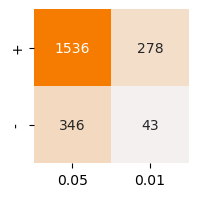

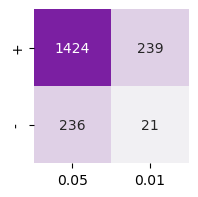

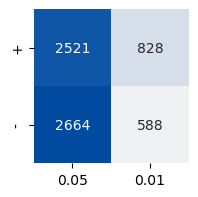

In [83]:
os.makedirs("../figures/sfigures/sfigure8/panel_B/", exist_ok=True)

c_color_dict = {"CD4": orange, "viralload":purple, "cfHIV":dark_blue}
for c in ["CD4", "viralload", "cfHIV"]:
    df = pd.DataFrame(index=["+", "-"], columns=["0.05", "0.01"])
    df.loc["+", "0.05"] = clin_num_correlated.loc[c, "u5"]
    df.loc["-", "0.05"] = clin_num_correlated.loc[c, "d5"]
    df.loc["+", "0.01"] = clin_num_correlated.loc[c, "u1"]
    df.loc["-", "0.01"] = clin_num_correlated.loc[c, "d1"]
    df = df.astype(int)
    figsize(2, 2)
    sns.heatmap(df, annot=True, fmt='d', cbar=False, cmap=sns.light_palette(c_color_dict[c], as_cmap=True))
    plt.savefig("../figures/sfigures/sfigure8/panel_B/correlation_{}_numbers.svg".format(c))
    plt.show()

## Panel C

In [85]:
meta1 = pd.read_csv('../tables/metadata.csv', index_col = 0)

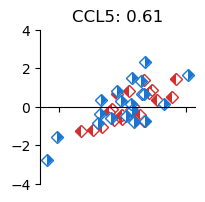

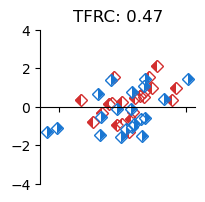

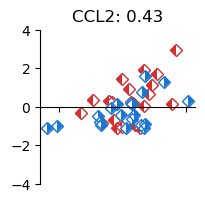

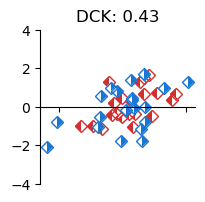

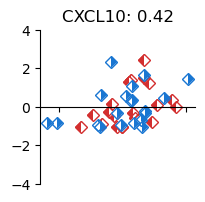

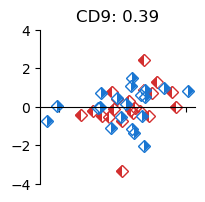

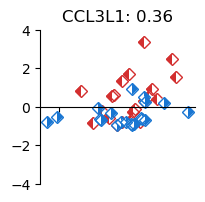

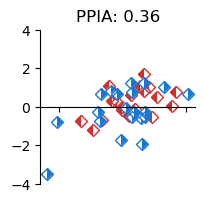

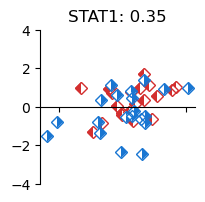

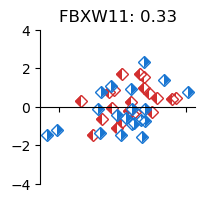

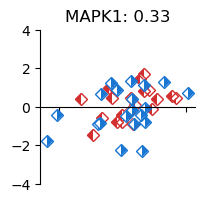

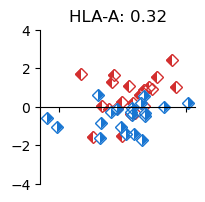

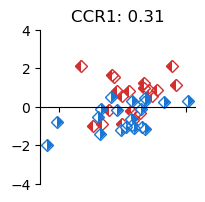

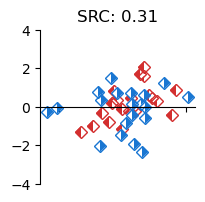

In [86]:
# Scatter plots of most correlated (HIV) genes
os.makedirs("../figures/sfigures/sfigure8/panel_C/", exist_ok=True)
top_correlated_cfHIV = clin_gene_corr.query("cfHIV_p <= 0.05").reindex(hiv_ensembl).dropna()

figsize(2, 2)
for g in top_correlated_cfHIV.sort_values(by="cfHIV", ascending=False).index:
    x = meta1.loc[X.index, "cfHIV"]
    y = logCPM.loc[g, X.index]
    y -= y.mean()
    y /= y.std() # z-score of gene expression
    # Different colours and styles for the two groups
    i = design.loc[x.index].query("bNAbs == 'Y'").index
    plt.plot(x.loc[i], y.loc[i], color=red, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle="left")
    plt.plot(x.loc[i], y.loc[i], color=red, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
    i = design.loc[x.index].query("bNAbs == 'N'").index
    plt.plot(x.loc[i], y.loc[i], color=blue, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle="right")
    plt.plot(x.loc[i], y.loc[i], color=blue, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
    plt.ylim(-4, 4)
    plt.xscale("log")
    plt.title("{}: {:.2f}".format(ensembl.loc[g, "Gene name"], clin_gene_corr.loc[g, "cfHIV"]))
    ax = plt.gca()
    ax.spines['bottom'].set_position('center')
    plt.xticks([0.1, 100], ["", ""])
    sns.despine()
    
    plt.savefig("../figures/sfigures/sfigure8/panel_C/{}.svg".format(ensembl.loc[g, "Gene name"]))
    plt.show()

# Figure S9 - Enrichrf gene pathways in bNAb producers

## Panel A - Differential Expression

In [87]:
# Load gene names and HIV associated genes
ensembl = pd.read_table("../tables/ensembl.tsv", index_col=0)
ensembl_clean = ensembl[ensembl["Gene name"].apply(lambda s: len(s.split("-"))) == 1]

hiv_genes = pd.read_excel("../tables/MalaCards-HIV.xlsx", index_col=0)
hiv_genes["gene"] = hiv_genes["Symbol"].apply(lambda s: s.split()[0])
hiv_genes.index = hiv_genes["gene"]
hiv_ensembl = [g for g in ensembl.index if ensembl.loc[g, "Gene name"] in hiv_genes["gene"].values]

In [88]:
# Build HIV Ensembl ID set from MalaCards sheet via gene symbols
hiv_symbols = (
    hiv_genes["Symbol"]
    .astype(str)
    .str.split().str[0]       # take first token like you did
    .str.upper()
    .unique()
)

# Normalize ensembl gene symbols to match casing and tokenization
ensembl["SYMBOL_UP"] = (
    ensembl["Gene name"].astype(str).str.split().str[0].str.upper())

hiv_ensembl_ids = set(
    ensembl.index[ensembl["SYMBOL_UP"].isin(hiv_symbols)])

In [89]:
# DE table
de_bNAbs = pd.read_table("../tables/bNAbs.de.new.txt", index_col=0)

# robust -log10(FDR)
de_bNAbs["-logP"] = -np.log10(de_bNAbs["FDR"].clip(lower=np.finfo(float).tiny))


In [90]:
# Add "Gene name"
de_bNAbs = de_bNAbs.join(ensembl[["Gene name"]], how="left").copy()

# Add HIV? flag by checking whether DE Ensembl IDs are in the HIV set
de_bNAbs["HIV?"] = de_bNAbs.index.isin(hiv_ensembl_ids)
#de_bNAbs.to_csv("differential_expression_bNAbs.txt", sep="\t")

In [91]:
#  quick diagnostics
missing = de_bNAbs.index[de_bNAbs["Gene name"].isna()]
if len(missing):
    print(f"{len(missing)} Ensembl IDs in DE not found in ensembl.tsv, e.g.: {list(missing[:10])}")

14 Ensembl IDs in DE not found in ensembl.tsv, e.g.: ['ENSG00000150076', 'ENSG00000272053', 'ENSG00000116957', 'ENSG00000276736', 'ENSG00000208034', 'ENSG00000133808', 'ENSG00000280954', 'ENSG00000281255', 'ENSG00000188206', 'ENSG00000155640']


In [92]:

unmatched_symbols = sorted(set(hiv_symbols) - set(ensembl["SYMBOL_UP"]))
if unmatched_symbols:
    print(f"{len(unmatched_symbols)} HIV symbols not found in ensembl.tsv, e.g.: {unmatched_symbols[:10]}")




2 HIV symbols not found in ensembl.tsv, e.g.: ['ERVK-6', 'LOC102724297']


In [93]:
print("bNABs = Y", len(de_bNAbs.query("logFC > 1").query("FDR < 0.05")))
print("bNABs = N", len(de_bNAbs.query("logFC < -1").query("FDR < 0.05")))

bNABs = Y 256
bNABs = N 281


In [94]:
def plot_GO_bars(df, n=20, color='k', title="", savefig=None, xlim=None,
                 genes="# Matched Genes", total_genes="# Genes"):
    figsize(4, 8)
    x = df["Score"].head(n=n)[::-1]
    x.plot.barh(color=color, width=0.8)
    # Labels
    for i,s in enumerate(x.index):
        plt.text(x.loc[s]+1, i, 
                 "{}/{}".format(df.loc[s, genes], df.loc[s, total_genes]), va="center")
    if xlim is not None:
        plt.xlim(*xlim)
    plt.xlabel("Score")
    plt.ylabel("")
    plt.title(title)
    sns.despine()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

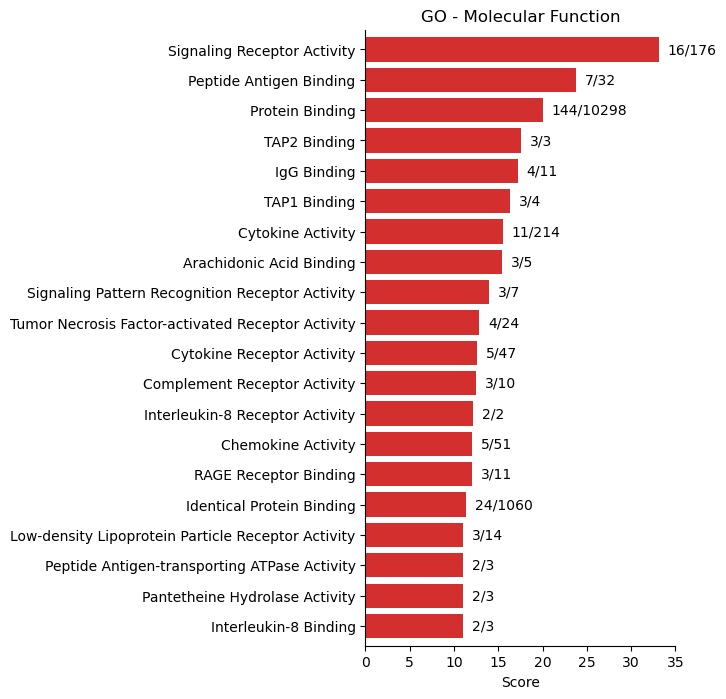

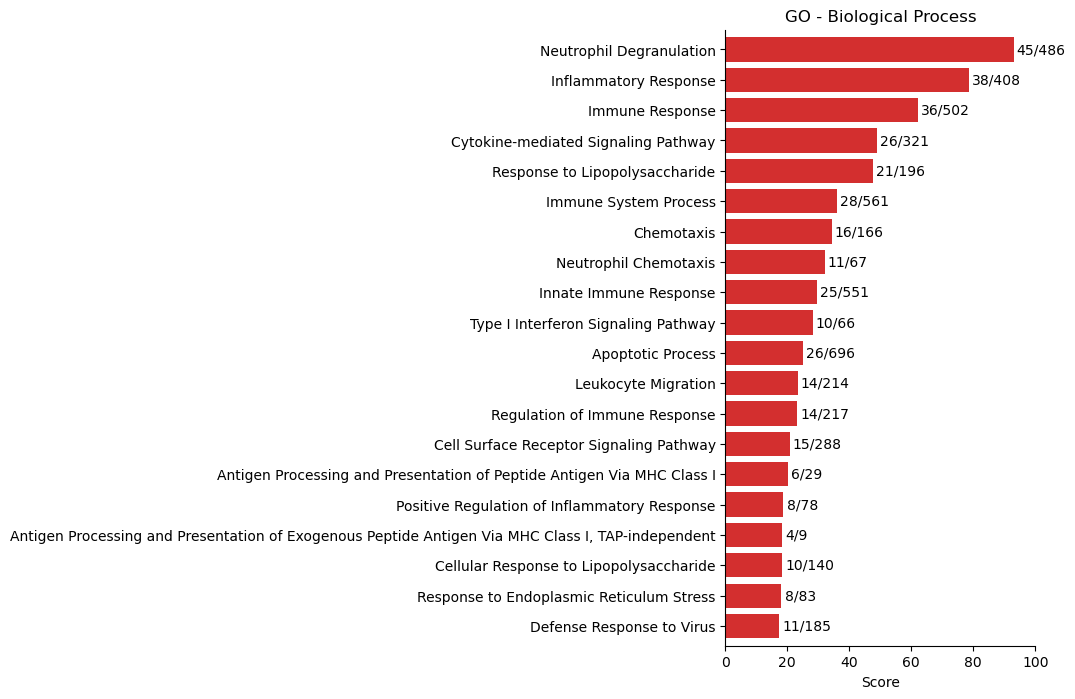

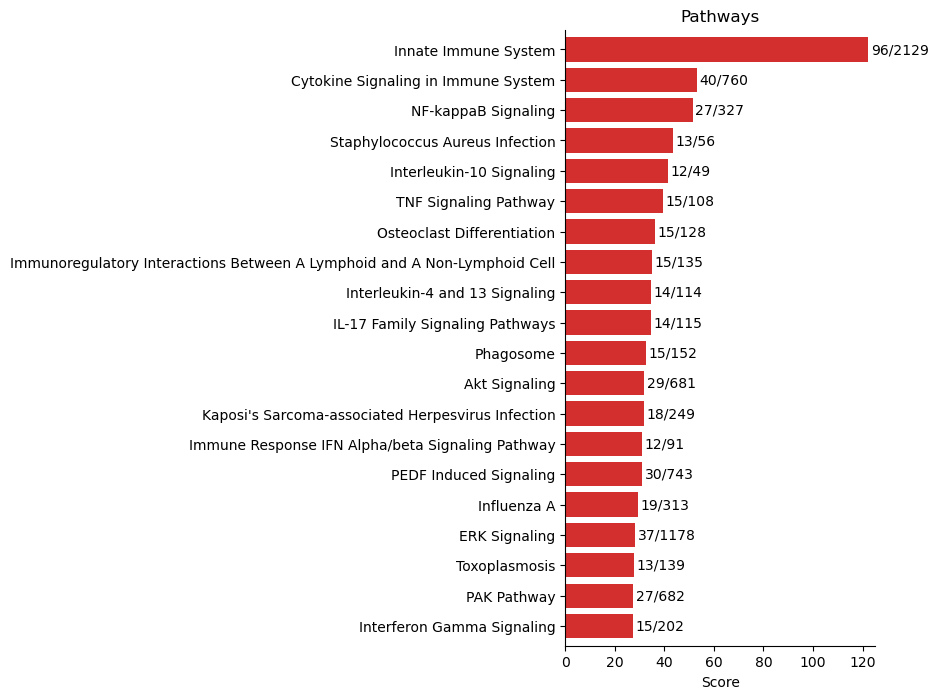

In [96]:
os.makedirs("../figures/sfigures/sfigure9/panel_A/", exist_ok=True)
up_go_mf = pd.read_excel("../tables/bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20181127-105723786.xlsx", 
              sheet_name="GO - Molecular Function", skiprows=18, index_col=1)
plot_GO_bars(up_go_mf, color=red, title="GO - Molecular Function", savefig="../figures/sfigures/sfigure9/panel_A/GA_GOMF_bNAbs.svg", xlim=(0, 35))

up_go_bp = pd.read_excel("../tables/bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20181127-105723786.xlsx", 
              sheet_name="GO - Biological Process", skiprows=18, index_col=1)
plot_GO_bars(up_go_bp, color=red, title="GO - Biological Process", savefig="../figures/sfigures/sfigure9/panel_A/GA_GOBP_bNAbs.svg", xlim=(0, 100))

up_pathways = pd.read_excel("../tables/bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20181127-105723786.xlsx", 
              sheet_name="Pathways", skiprows=18, index_col=1)
plot_GO_bars(up_pathways, color=red, title="Pathways", 
             genes="# SuperPath Matched Genes", total_genes="# SuperPath Total Genes", 
             savefig="../figures/sfigures/sfigure9/panel_A/GA_pathways_bNAbs.svg", xlim=(0, 125))

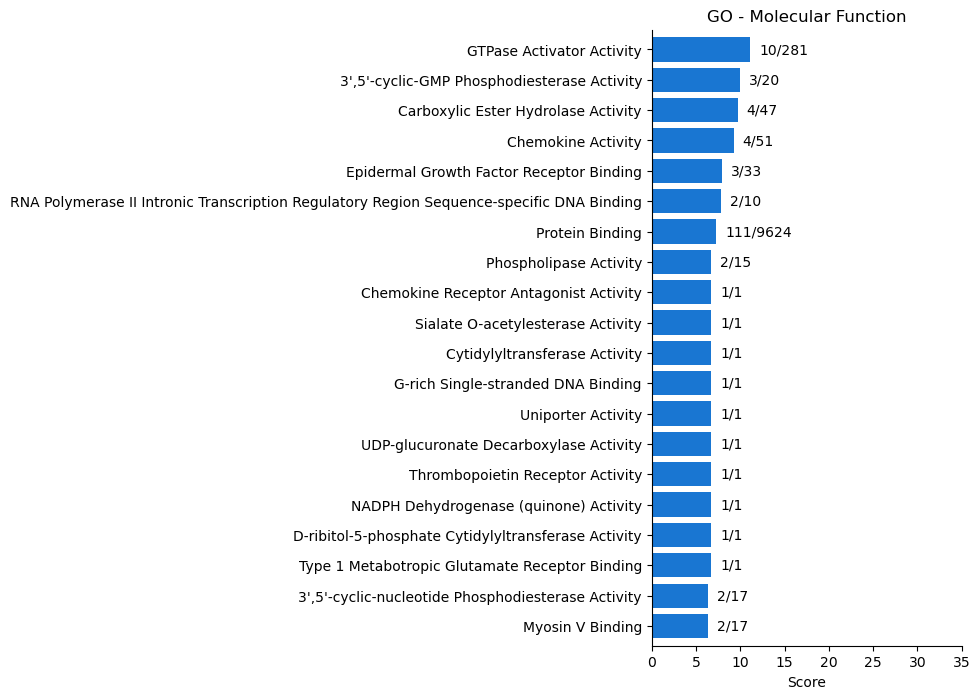

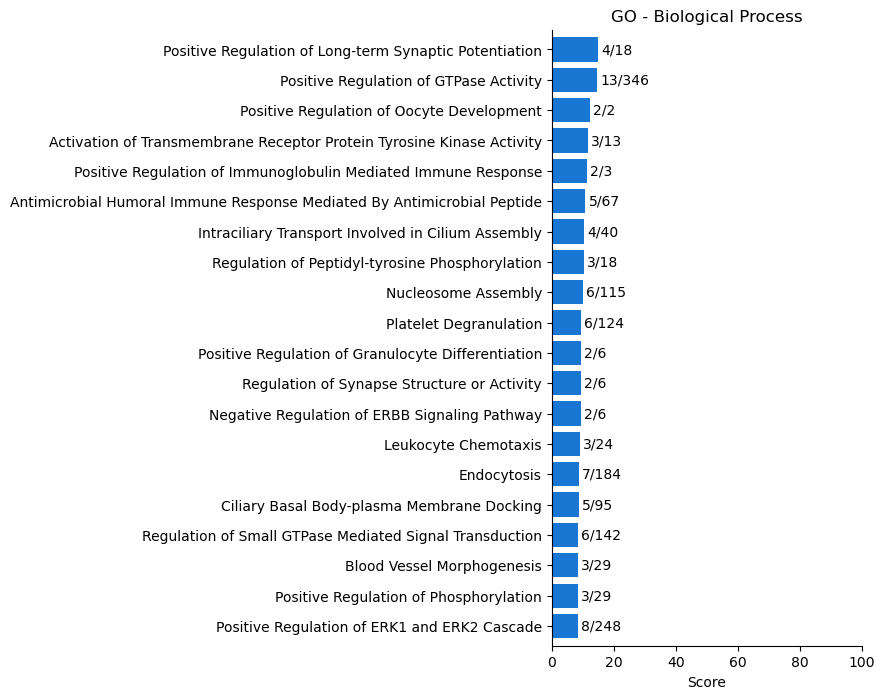

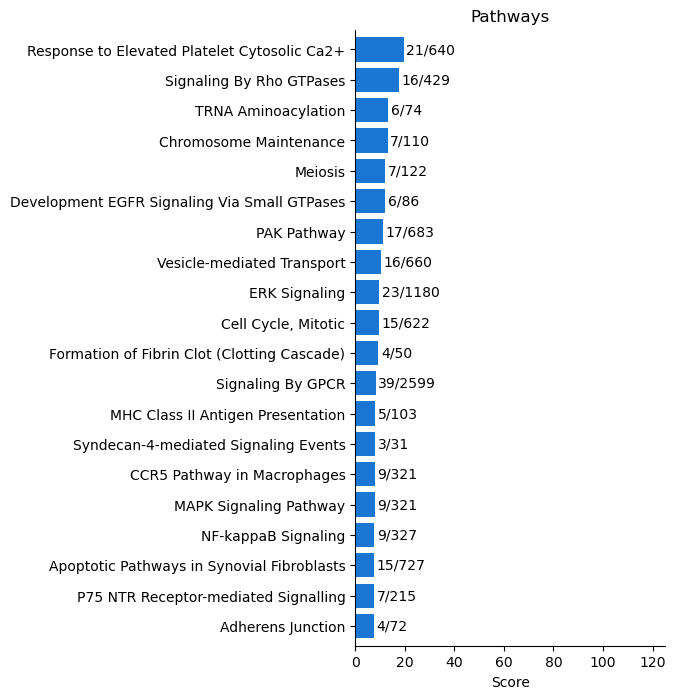

In [97]:
os.makedirs("../figures/sfigures/sfigure9/panel_B/", exist_ok=True)
down_go_mf = pd.read_excel("../tables/not-bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20190326-050855667.xlsx", 
              sheet_name="GO - Molecular Function", skiprows=18, index_col=1)
plot_GO_bars(down_go_mf, color=blue, title="GO - Molecular Function", savefig="../figures/sfigures/sfigure9/panel_B/GA_GOMF_notbNAbs.svg", 
             xlim=(0, 35))

down_go_bp = pd.read_excel("../tables/not-bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20190326-050855667.xlsx", 
              sheet_name="GO - Biological Process", skiprows=18, index_col=1)
plot_GO_bars(down_go_bp, color=blue, title="GO - Biological Process", savefig="../figures/sfigures/sfigure9/panel_B/GA_GOBP_notbNAbs.svg",
            xlim=(0, 100))

down_pathways = pd.read_excel("../tables/not-bNAbs-GeneAnalytics_Results_ayeletv-stanford-edu-20190326-050855667.xlsx", 
              sheet_name="Pathways", skiprows=18, index_col=1)
plot_GO_bars(down_pathways, color=blue, title="Pathways", 
             genes="# SuperPath Matched Genes", total_genes="# SuperPath Total Genes", 
             savefig="../figures/sfigures/sfigure9/panel_B/GA_pathways_notbNAbs.svg", xlim=(0, 125))

### Correlation with production of bNAbs

## Panel C

In [98]:
breadth_corr = pd.read_csv("../tables/breadth_gene_correlation.txt", sep="\t", index_col=0)

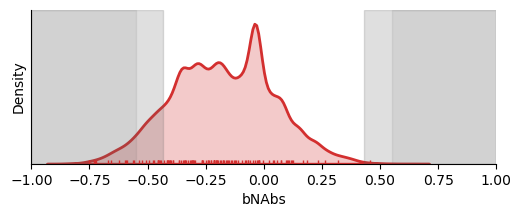

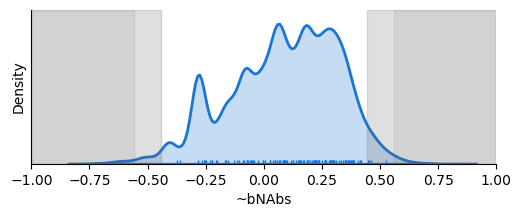

In [99]:
os.makedirs("../figures/sfigures/sfigure9/panel_C/", exist_ok=True)
figsize(6, 2)
sns.kdeplot(breadth_corr["bNAbs"].dropna(), shade=True, color=red, linewidth=2, legend=False)
sns.rugplot(breadth_corr["bNAbs"].reindex(hiv_ensembl).dropna(), color=red)
plt.axvspan(xmin=-1, xmax=-0.433, color=grey, alpha=0.2)
plt.axvspan(xmin=-1, xmax=-0.55, color=grey, alpha=0.1)
plt.axvspan(xmin=0.433, xmax=1, color=grey, alpha=0.2)
plt.axvspan(xmin=0.55, xmax=1, color=grey, alpha=0.1)
plt.yticks([])
sns.despine()
plt.xlim(-1, 1)
plt.savefig("../figures/sfigures/sfigure9/panel_C/correlation_breadth_bNAbs.svg")
plt.show()

sns.kdeplot(breadth_corr["~bNAbs"].dropna(), shade=True, color=blue, linewidth=2, legend=False)
sns.rugplot(breadth_corr["~bNAbs"].reindex(hiv_ensembl).dropna(), color=blue)
plt.axvspan(xmin=-1, xmax=-0.444, color=grey, alpha=0.2)
plt.axvspan(xmin=-1, xmax=-0.56, color=grey, alpha=0.1)
plt.axvspan(xmin=0.444, xmax=1, color=grey, alpha=0.2)
plt.axvspan(xmin=0.56, xmax=1, color=grey, alpha=0.1)
plt.yticks([])
sns.despine()
plt.xlim(-1, 1)
plt.savefig("../figures/sfigures/sfigure9/panel_C/correlation_breadth_notbNAbs.svg")
plt.show()

## Panel D

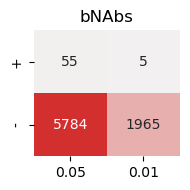

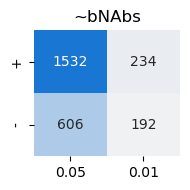

In [100]:
os.makedirs("../figures/sfigures/sfigure9/panel_D/", exist_ok=True)
c_color_dict = {"bNAbs": red, "~bNAbs": blue}

for c in ["bNAbs", "~bNAbs"]:
    bc = breadth_corr  # alias for readability
    assert c in bc.columns and f"{c}_p" in bc.columns, f"Missing columns for {c}"

    df = pd.DataFrame(index=["+", "-"], columns=["0.05", "0.01"], dtype=int)

    df.loc["+", "0.05"] = ((bc[c] > 0) & (bc[f"{c}_p"] <= 0.05)).sum()
    df.loc["-", "0.05"] = ((bc[c] < 0) & (bc[f"{c}_p"] <= 0.05)).sum()
    df.loc["+", "0.01"] = ((bc[c] > 0) & (bc[f"{c}_p"] <= 0.01)).sum()
    df.loc["-", "0.01"] = ((bc[c] < 0) & (bc[f"{c}_p"] <= 0.01)).sum()

    figsize(2, 2)
    sns.heatmap(
    df,                 
    annot=True,
    fmt='.0f',          # show as integers
    cbar=False,
    cmap=sns.light_palette(c_color_dict[c], as_cmap=True),
    )

    plt.title(c)
    plt.tight_layout()
    plt.savefig(f'../figures/sfigures/sfigure9/panel_D/{c}.svg')
    plt.show()


# S10 - Background microbial sequences in negative controls

In [174]:

import pickle, gzip

In [102]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="taxid .* was translated into .*",
    category=UserWarning,
)

In [103]:
%load_ext autoreload
%autoreload 2
import sys
import importlib
sys.path.append("./")

import run_modelling_cleaned as rm
importlib.reload(rm)

<module 'run_modelling_cleaned' from '/home/mercedes/Documents/projects/github/cfHIV/final_repo/cfHIV/notebooks/run_modelling_cleaned.py'>

In [105]:

DOMAINS = ["bacteria", "archaea", "viruses"]
RANKS = ["species", "genus", "family", "order", "class", "phylum"]


def load_domain_results_pickle(path="../tables/domain_results.pkl.gz"):
    # --- compatibility aliases for older/newer numpy internals ---
    import numpy.core as _np_core
    import numpy.core.numeric as _np_numeric

    sys.modules.setdefault("numpy._core", _np_core)
    sys.modules.setdefault("numpy._core.numeric", _np_numeric)

    with gzip.open(path, "rb") as f:
        return pickle.load(f)

domain_results = load_domain_results_pickle("../tables/domain_results.pkl.gz")

In [106]:
DOMAIN = "bacteria"
rank = "genus"

counts = domain_results[DOMAIN]["rank_tables"][rank]
meta = domain_results[DOMAIN]["meta"]

In [107]:


def load_gzip_pickle(path):
    with gzip.open(path, "rb") as f:
        obj = pickle.load(f)
    return obj

res_bg   = load_gzip_pickle("../tables/edger_plasma_vs_water_res.pkl.gz")
logcpm   = load_gzip_pickle("../tables/edger_plasma_vs_water_logcpm.pkl.gz")
meta_pw  = load_gzip_pickle("../tables/edger_plasma_vs_water_meta.pkl.gz")


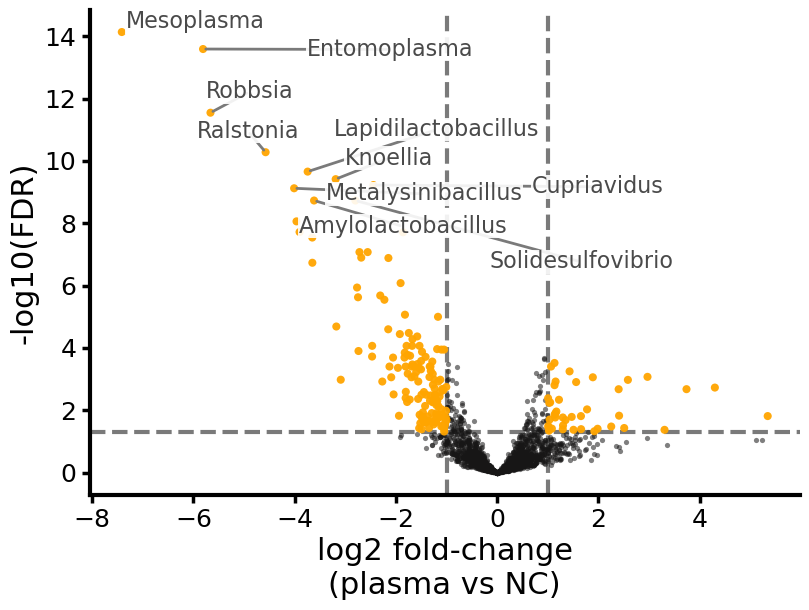

In [110]:

a, _ = rm.volcano_plot_fdr(res_bg)
os.makedirs("../figures/sfigures/sfigure10/", exist_ok=True)
a.savefig('../figures/sfigures/sfigure10/volcano_water.svg')

# Figure S11 - Infectome

In [111]:
ncbi = NCBITaxa()
def taxid_to_kingdom_color(taxid):
    try:
        l = ncbi.get_lineage(taxid)
        if 2 in l:
            return light_red
        elif 10239 in l:
            return light_green
        else:
            return light_purple
    except:
        print(taxid)
        return light_red

In [175]:

ia = pd.read_parquet("../tables/accession_taxid.parquet")

print("accession_taxid rows:", ia.shape[0])

accession_taxid rows: 1962798


In [176]:
# bad RNA and bad DNA
bad_rna = pd.read_csv("../tables/bad_rna.csv")
bad_dna = pd.read_csv("../tables/bad_dna.csv")

In [177]:
dna_samples = pd.read_csv("../tables/dna_samples.csv.bz2", index_col=0)
rna_samples = pd.read_csv("../tables/rna_samples.csv.bz2", index_col=0)

In [178]:
# RNA
x = rna_samples.loc[rna_samples.index.difference(bad_rna)]

# ribosomal part
print(100*x.reindex(ia[ia["name"].apply(lambda s: "16S" in s)].index).sum().sum()/x.sum().sum())

38.52322919181843


In [179]:
r = x.copy()
r["taxid"] = ia.loc[r.index, "taxid"]
r = r.groupby(by="taxid").sum()

In [129]:
counts = 100*r.sum(axis=1)/x.sum().sum()
counts.sort_values(ascending=False, inplace=True)
counts =counts[~ (counts.index == '1358;1359')].copy()
taxids = counts.index[:243] # 70% of reads

In [130]:
[(t, counts.loc[t], ncbi.get_taxid_translator([int(t)])[int(t)]) for t in counts.index[:10]]

[('77133', 18.027401239892107, 'uncultured bacterium'),
 ('115547', 10.096212526885187, 'uncultured archaeon'),
 ('54290', 7.816424539056396, 'GB virus C'),
 ('1542133', 3.907281638434384, 'Dickeya phage phiDP23.1'),
 ('55601', 2.912220878597744, 'Vibrio anguillarum'),
 ('36452', 1.8938342118762796, 'Stealth virus 1'),
 ('2306583', 1.4843895730286443, 'Halomonas sp. JS92-SW72'),
 ('1758225', 1.409930248594381, 'Human pegivirus'),
 ('11676', 1.1671239664358115, 'Human immunodeficiency virus 1'),
 ('1491', 1.1356798673298767, 'Clostridium botulinum')]

In [131]:
def pruned_contaminant_tree(taxids, counts,
                  plotted_levels=["no rank", "superkingdom", "phylum", "class", "order", "family", "genus", "species"]):
    """ Creates a pruned tree of the contigs and their tax info """
    tree = ncbi.get_topology(set(taxids), intermediate_nodes=True)
    
    for taxid in taxids:
        try:
            taxid_ = ncbi.get_lineage(taxid)[-1] # Fix name translations
            t = tree & taxid_
            t.add_feature("num", counts.loc[taxid])
        except:
            print(taxid, "ignored")
            t = tree & taxid_
            print(t)
            t.add_feature("num", counts.loc[taxid])
    for t in tree.traverse():
        t.num = sum([node.num if "num" in node.features else 0 for node in t.iter_leaves()])
    # Remove other levels
    for t in tree.iter_descendants(strategy="postorder"):
        if t.rank not in plotted_levels and t.up is not None:
            t.delete(prevent_nondicotomic=False)
        for t in tree.iter_descendants():
            if t.rank == 'no rank' and t.up is not None:
                t.delete(prevent_nondicotomic=False)
    return tree

In [132]:
fsize=16
def layout(node, label=False, color='k'):
    style = NodeStyle()
    style["size"] = np.sqrt(node.num)
    style["shape"] = "sphere"
    style["fgcolor"] = color
    style["vt_line_width"] = 2
    style["hz_line_width"] = 2
    node.set_style(style)
    if label:
        face = faces.AttrFace("sci_name", fsize=fsize)
        #face.rotation = 90
        faces.add_face_to_node(face, node, 0)
        
ts_l = TreeStyle()
ts_l.layout_fn = lambda x: layout(x, label=True, color=dark_red)
ts_l.show_leaf_name = False
ts_l.show_scale = False
ts_l.mode = "r"
#ts_l.branch_vertical_margin = 1

ts = TreeStyle()
ts.layout_fn = lambda x: layout(x, label=False, color=dark_red)
ts.show_leaf_name = False
ts.show_scale = False
ts.mode = "r"
#ts.branch_vertical_margin = 20

In [133]:
tree = pruned_contaminant_tree(taxids, counts*100)

## Panel B

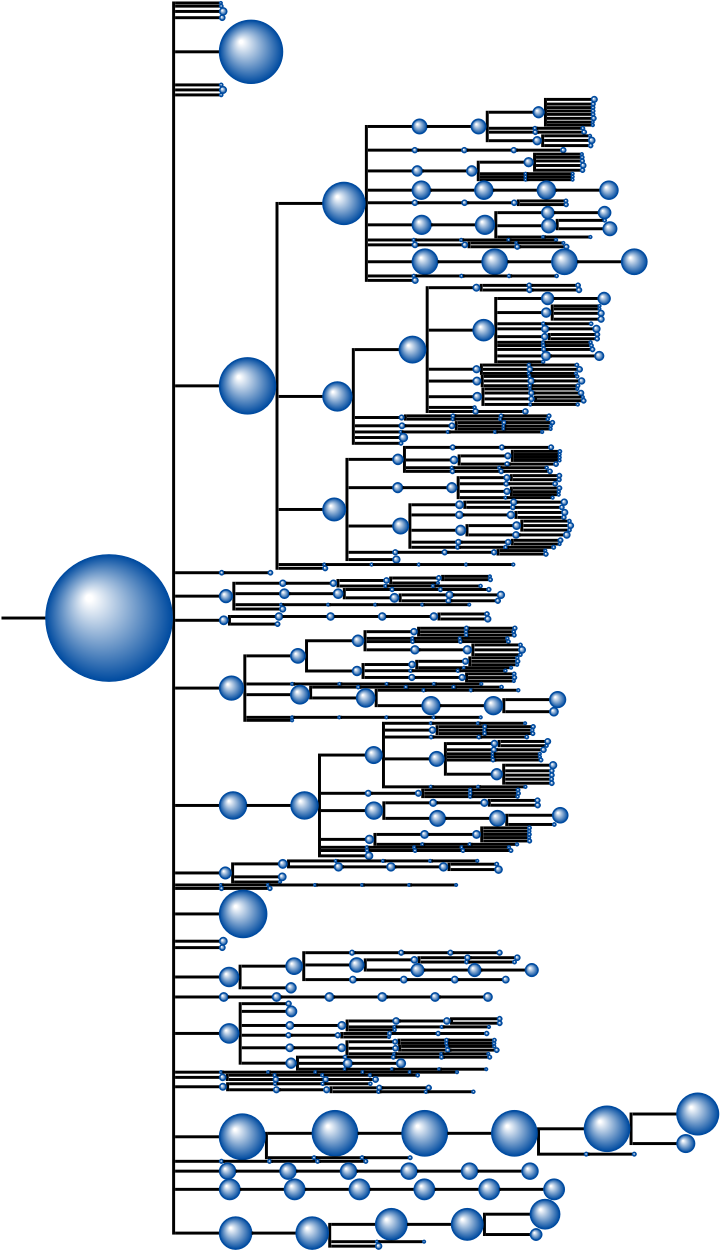

In [134]:
os.makedirs("../figures/sfigures/sfigure11/panel_B/", exist_ok=True)

ts_l = TreeStyle()
ts_l.layout_fn = lambda x: layout(x, label=True, color=dark_blue)
ts_l.show_leaf_name = False
ts_l.show_scale = False
ts_l.mode = "r"
#ts_l.branch_vertical_margin = 1

ts = TreeStyle()
ts.layout_fn = lambda x: layout(x, label=False, color=dark_blue)
ts.show_leaf_name = False
ts.show_scale = False
ts.mode = "r"

tree.render("../figures/sfigures/sfigure11/panel_B/rna_tree.svg", tree_style=ts, units='in', w=8)
tree.render("%%inline", tree_style=ts, units='in', w=8)

In [135]:
# DNA
x = dna_samples.loc[dna_samples.index.difference(bad_dna)]

d = x.copy()
d["taxid"] = ia.loc[d.index, "taxid"]
d = d.groupby(by="taxid").sum()

In [136]:
counts = 100*d.sum(axis=1)/x.sum().sum()
counts.sort_values(ascending=False, inplace=True)
taxids = counts.index[:66] # 70% of reads

In [137]:
[(t, counts.loc[t], ncbi.get_taxid_translator([int(t)])[int(t)]) for t in counts.index[:10]]

[('615', 18.91572428399933, 'Serratia marcescens'),
 ('1758196', 12.865407149293713, 'Serratia sp. SSNIH1'),
 ('368607', 6.779106732974321, 'Janthinobacterium svalbardensis'),
 ('2590869', 6.507643115557592, 'Janthinobacterium tructae'),
 ('294', 2.3683355323116544, 'Pseudomonas fluorescens'),
 ('55508', 1.573320293238116, 'Janthinobacterium agaricidamnosum'),
 ('2478662', 1.3155938830471585, 'Acidovorax sp. 1608163'),
 ('1334564', 1.196982325135091, 'Serratia marcescens SM39'),
 ('273526', 1.1416234303446706, 'Serratia marcescens subsp. marcescens Db11'),
 ('1938606', 1.0456680127079419, 'Janthinobacterium sp. LM6')]

In [138]:
tree = pruned_contaminant_tree(taxids, counts*100)

## Panel A

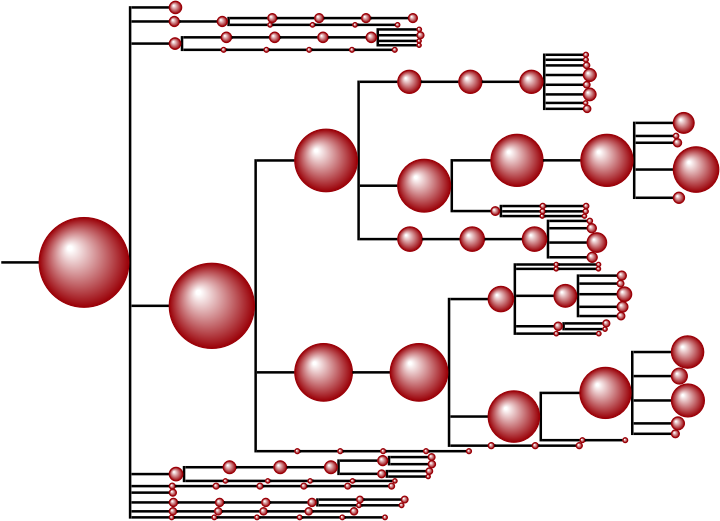

In [139]:
os.makedirs("../figures/sfigures/sfigure11/panel_A/", exist_ok=True)
ts_l = TreeStyle()
ts_l.layout_fn = lambda x: layout(x, label=True, color=dark_red)
ts_l.show_leaf_name = False
ts_l.show_scale = False
ts_l.mode = "r"
#ts_l.branch_vertical_margin = 1

ts = TreeStyle()
ts.layout_fn = lambda x: layout(x, label=False, color=dark_red)
ts.show_leaf_name = False
ts.show_scale = False
ts.mode = "r"

tree.render("../figures/sfigures/sfigure11/panel_A/dna_tree.svg", tree_style=ts, units='in', w=8)
tree.render("%%inline", tree_style=ts, units='in', w=8)
#plt.savefig('figures/sfigures/dna_tree.svg')


## S12 - Subset of microbial genera enriched in bNAb producers

In [141]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./")

import run_modelling_cleaned as rm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="taxid .* was translated into .*",
    category=UserWarning,
)

In [145]:

DOMAINS = ["bacteria", "archaea", "viruses"]
RANKS = ["species", "genus", "family", "order", "class", "phylum"]


def load_domain_results_pickle(path="../tables/domain_results.pkl.gz"):
    # --- compatibility aliases for older/newer numpy internals ---
    import numpy.core as _np_core
    import numpy.core.numeric as _np_numeric

    sys.modules.setdefault("numpy._core", _np_core)
    sys.modules.setdefault("numpy._core.numeric", _np_numeric)

    with gzip.open(path, "rb") as f:
        return pickle.load(f)

domain_results = load_domain_results_pickle("../tables/domain_results.pkl.gz")

In [148]:
DOMAIN = "bacteria"
rank = "genus"

counts = domain_results[DOMAIN]["rank_tables"][rank]
meta = domain_results[DOMAIN]["meta"]

In [149]:


def load_gzip_pickle(path):
    with gzip.open(path, "rb") as f:
        obj = pickle.load(f)
    return obj

res_bg   = load_gzip_pickle("../tables/edger_plasma_vs_water_res.pkl.gz")
logcpm   = load_gzip_pickle("../tables/edger_plasma_vs_water_logcpm.pkl.gz")
meta_pw  = load_gzip_pickle("../tables/edger_plasma_vs_water_meta.pkl.gz")


In [150]:
# Original list of significant families - edit this to remove groups to plot!
orig_list1 = [
    {1849828: 'Paeniclostridium'},
    {1335483: 'Shimwellia'},
    {32067: 'Leptotrichia'},
    {1903434: 'Atlantibacter'},
    {158483: 'Cedecea'},
    {114627: 'Alkaliphilus'},
    {1651: 'Alloiococcus'},
    {613: 'Serratia'},
    {1501226: 'Romboutsia'},
    {83654: 'Leclercia'},
    {409304: 'Candidatus Ishikawella'},
    {32257: 'Kingella'},
    {1824856: 'Oceanivirga'},
    {1870884: 'Clostridioides'},
    {160674: 'Raoultella'},
    {216387: 'Candidatus Amoebinatus'},
    {267408: 'Arsenicicoccus'}
]
orig_list2 = [
    {28895: 'Thermoanaerobacterium'},
    {203470: 'Tepidiphilus'},
    {2742598: 'Limosilactobacillus'},
    {46255: 'Weissella'},
    {332248: 'Truepera'}
]

orig_names = {list(d.values())[0] for d in (orig_list1 + orig_list2)}
orig_names


{'Alkaliphilus',
 'Alloiococcus',
 'Arsenicicoccus',
 'Atlantibacter',
 'Candidatus Amoebinatus',
 'Candidatus Ishikawella',
 'Cedecea',
 'Clostridioides',
 'Kingella',
 'Leclercia',
 'Leptotrichia',
 'Limosilactobacillus',
 'Oceanivirga',
 'Paeniclostridium',
 'Raoultella',
 'Romboutsia',
 'Serratia',
 'Shimwellia',
 'Tepidiphilus',
 'Thermoanaerobacterium',
 'Truepera',
 'Weissella'}

In [151]:

meta3 = meta.copy()
meta3["group3"] = meta3["group"]

# align design_df to meta index
common = meta3.index.intersection(design.index)

missing_in_meta = design.index.difference(meta3.index)
if len(missing_in_meta) > 0:
    print("Design samples not in meta (will be ignored):", list(missing_in_meta))

# assign bNAbs only where sample exists
meta3.loc[common, "bNAbs"] = design.loc[common, "bNAbs"].astype(str)

# define 3-level group
meta3["group3"] = np.where(
    meta3["group"].eq("water"), "water",
    np.where(meta3["bNAbs"].eq("Y"), "plasma_bNAbs+", "plasma_bNAbs-")
)

meta3["group3"].value_counts()


Design samples not in meta (will be ignored): ['SAMPLE_100200_1']


group3
plasma_bNAbs-    28
plasma_bNAbs+    21
water             6
Name: count, dtype: int64

In [152]:
paper_taxa = sorted(list(orig_names))

X = logcpm.loc[logcpm.index.intersection(paper_taxa)]
X = X.loc[:, X.columns.intersection(meta3.index)]

df_long3 = (
    X.T
     .assign(group3=meta3.loc[X.columns, "group3"])
     .reset_index(names="sample")
     .melt(id_vars=["sample", "group3"], var_name="Genus", value_name="value")
)


In [153]:

# keep only plasma + water
m = meta3.loc[X.columns].copy()
m = m[m["group"].isin(["plasma", "water"])]
X = X.loc[:, m.index]

# water-only mean/sd per genus
water_cols = m.index[m["group"].eq("water")]
mu = X[water_cols].mean(axis=1)
sd = X[water_cols].std(axis=1, ddof=1).replace(0, np.nan)

Z = X.sub(mu, axis=0).div(sd, axis=0).replace([np.inf, -np.inf], np.nan)

df_new = (
    Z.T
     .assign(
         sample=lambda d: d.index,
         group_box=np.where(m.loc[Z.columns, "group"].eq("water"), "water", "plasma"),
         bNAbs=m.loc[Z.columns, "bNAbs"].astype(str)
     )
     .reset_index(drop=True)
     .melt(id_vars=["sample", "group_box", "bNAbs"], var_name="Genus", value_name="value")
)

df_new["bNAbs"] = df_new["bNAbs"].map({"Y": "bNAbs+", "N": "bNAbs-"}).fillna(df_new["bNAbs"])
ylab = "Z-score relative to water controls"


In [154]:

# water median per genus
water_cols = m.index[m["group"].eq("water")]
water_median = X[water_cols].median(axis=1)

# median-over-water centered matrix
X_med = X.sub(water_median, axis=0)


In [155]:
# ensure bNAbs labels are present for plasma samples in meta3

group3 = pd.Series(index=m.index, dtype="object")
group3.loc[m.index[m["group"].eq("water")]] = "water"

plasma_idx = m.index[m["group"].eq("plasma")]
bn = m.loc[plasma_idx, "bNAbs"].astype(str).map({"Y":"plasma_bNAbs+","N":"plasma_bNAbs-"})
group3.loc[plasma_idx] = bn

order3 = ["water", "plasma_bNAbs-", "plasma_bNAbs+"]
group3 = pd.Categorical(group3, categories=order3, ordered=True)


In [156]:

df3_med = (
    X_med.T
        .assign(sample=lambda d: d.index, group3=group3)
        .reset_index(drop=True)
        .melt(id_vars=["sample", "group3"], var_name="Genus", value_name="value")
)

ylab_med = "Δ logCPM (rel water median)"


In [157]:
preselected = ['Atlantibacter','Serratia','Leclercia','Raoultella','Cedecea']
df3_selected = df3_med[df3_med['Genus'].isin(preselected)].copy()

In [158]:
df3_selected['group3'] = (
    df3_selected['group3']
    .cat.rename_categories({'plasma_bNAbs+':'bNABs',
                                'plasma_bNAbs-':'No bNABs'}))

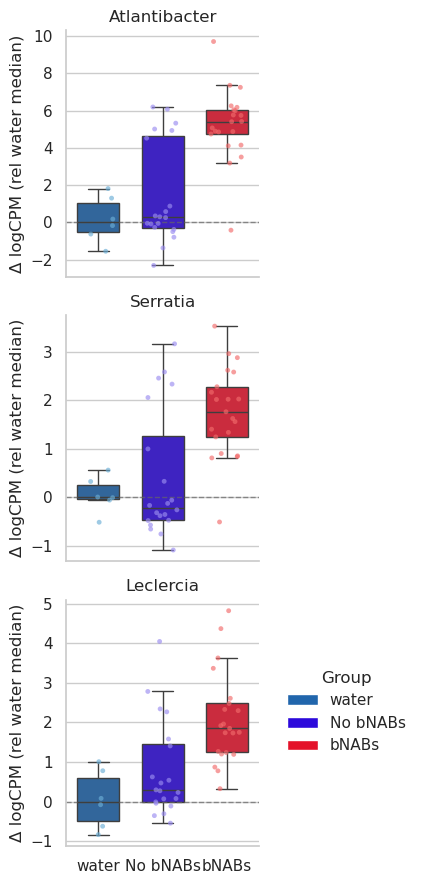

In [160]:
from matplotlib.patches import Patch
sns.set_theme(style="whitegrid")
palette3_light = {
    "water": "#6BAED6",          # light blue
    "No bNABs": "#9A8CF0",  # light indigo / purple-blue
    "bNABs": "#F26B6B",  # soft red
}

palette3 = {
    "water": "#2166AC",
    "No bNABs": "#2C09DB",
    "bNABs": "#E4122A",
}
order3=['water', 'No bNABs', 'bNABs']
order_sp= ['Atlantibacter','Serratia','Leclercia']
def box_only_bnabs(data, **kws):
    ax = plt.gca()

    sns.boxplot(
        data=data,
        x="group3",
        y="value",
        hue="group3",
        order=order3,
        palette=palette3,
        showfliers=False,
        width=0.65,
        ax=ax
    )

    sns.stripplot(
        data=data,
        x="group3",
        y="value",
        order=order3,
        hue="group3",
        palette=palette3_light,
        dodge=False,
        jitter=0.25,
        alpha=0.65,
        size=3.5,
        linewidth=0,
        ax=ax
    )

g = sns.FacetGrid(df3_selected, col_order = order_sp, col="Genus", col_wrap=1, sharey=False, height=3.0, aspect=0.95)
g.map_dataframe(box_only_bnabs)
g.set_axis_labels("", ylab_med)
g.set_titles("{col_name}")

for ax in g.axes.flat:
    ax.axhline(0, ls="--", lw=1, c="0.4", alpha=0.7)
    ax.tick_params(axis="x", rotation=0)




handles = [Patch(facecolor=palette3[k], label=k.replace("_", " ")) for k in order3]
g.fig.legend(
    handles=handles,
    title="Group",
    loc="center right",
    bbox_to_anchor=(1.5, 0.2),
    frameon=False
)


plt.tight_layout()
plt.show()
os.makedirs("../figures/sfigures/sfigure12/", exist_ok=True)
g.savefig('../figures/sfigures/sfigure12/boxplots_species.svg')

# Figure S13 - Pseudo-temporal dynamics in differentially abundant genera between bNAb producers and non-producers

In [161]:
de = pd.read_table("../tables/rna_genus_bNAbs.de.txt", index_col=0)
de["-logP"] = -np.log10(de["FDR"])

In [162]:
u = de.query("FDR < 0.05").query("logFC > 0").index
d = de.query("FDR < 0.05").query("logFC < 0").index

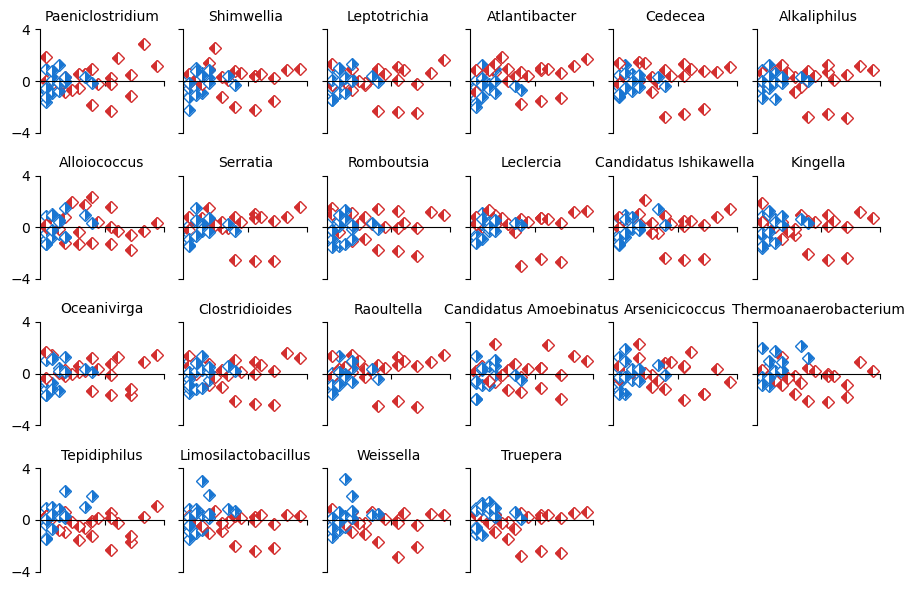

In [164]:
sns.reset_orig()
x = pd.read_table("../tables/just_rna_counts_genus.txt", index_col=0)

os.makedirs("../figures/sfigures/sfigure13/", exist_ok=True)
x = np.log10(x+1)

x = x.loc[list(u) + list(d)]
x = x.sub(x.mean(axis=1), axis=0)
x = x.div(x.std(axis=1), axis=0)
#x.index = ensembl.loc[x.index, "Gene name"]

f, axarr = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(1.5*6, 1.5*4))
axarr = axarr.flatten()

for i, g in enumerate(x.index):
    for s in x.columns:
        if design.loc[s, "bNAbs"] == "Y":
            color=red
            fillstyle="left"
        else:
            color=blue
            fillstyle="right"
        axarr[i].plot(100*breadth_metadata.loc[s, "% breadth"], x.loc[g, s], color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle=fillstyle)
        axarr[i].plot(100*breadth_metadata.loc[s, "% breadth"], x.loc[g, s], color=color, marker="D", 
                 markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none")
    title = ncbi.get_taxid_translator([int(g)])[int(g)]
    axarr[i].set_title("{}".format(title), fontsize=10)
    axarr[i].set_ylim(-4, 4)
    axarr[i].set_yticks([-4, 0, 4])
    axarr[i].set_xticks([50, 100])
    axarr[i].set_xticklabels(["", ""])
    axarr[i].spines['bottom'].set_position('center')
    sns.despine(ax=axarr[i])
    
axarr[-1].axis('off')
axarr[-2].axis('off')
plt.tight_layout()
plt.savefig("../figures/sfigures/sfigure13/S7_raw.svg")
plt.show()

# S14 - Coverage profiles of HCV and GBV-C genomes across samples

In [165]:
def load_depths(depth_glob, ref=None):
    dfs = []
    for p in sorted(glob.glob(depth_glob)):
        df = pd.read_csv(p, sep="\t", header=None, names=["ref","pos","depth"])
        if ref is not None:
            df = df[df["ref"] == ref]
        df["sample"] = p.split("/")[-1].replace(".depth.tsv","")
        dfs.append(df)
    return dfs


## Panel A


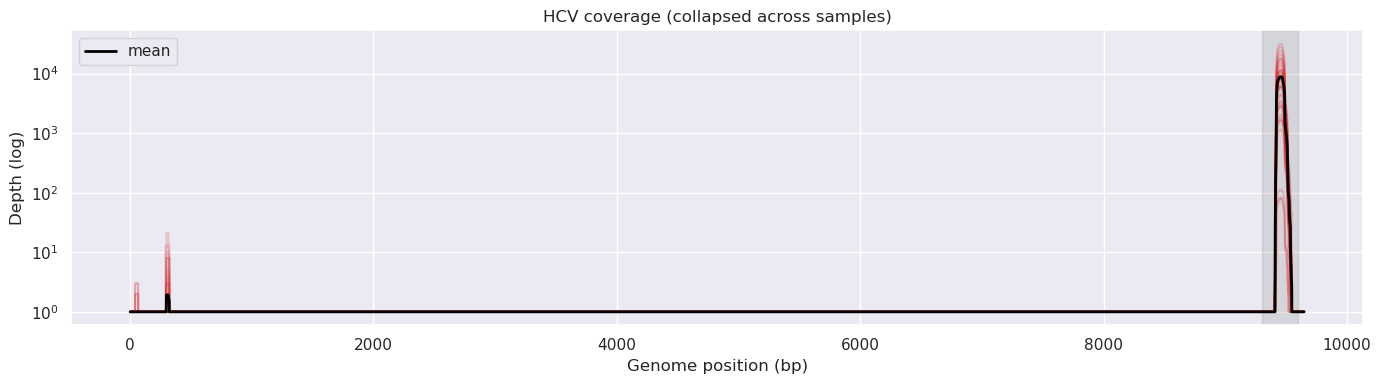

In [169]:
HCV_REF = "NC_004102.1"

# Load all sample files
hcv_dfs = load_depths("../tables/align_hcv_gbvc_tsv/*.HCV.depth.tsv", ref=HCV_REF)


# compute mean depth across samples
all_hcv = pd.concat(hcv_dfs)
mean_hcv = all_hcv.groupby("pos")["depth"].mean().reset_index()


sns.set_theme(font_scale = 1)
plt.figure(figsize=(14,4))
for df in hcv_dfs:
    plt.plot(df["pos"], np.maximum(df["depth"],1), color="tab:red", alpha=0.2)

plt.plot(mean_hcv["pos"], np.maximum(mean_hcv["depth"],1),
         color="black", linewidth=2, label="mean")

plt.yscale("log")
plt.xlabel("Genome position (bp)")
plt.ylabel("Depth (log)")
plt.title("HCV coverage (collapsed across samples)")
plt.axvspan(9300, 9600, color="grey", alpha=0.2)
plt.legend()
plt.tight_layout()

os.makedirs("../figures/sfigures/sfigure14/panel_A/", exist_ok=True)
plt.savefig('../figures/sfigures/sfigure14/panel_A/coverage_across_hcv.svg')
plt.show()



## Panel B

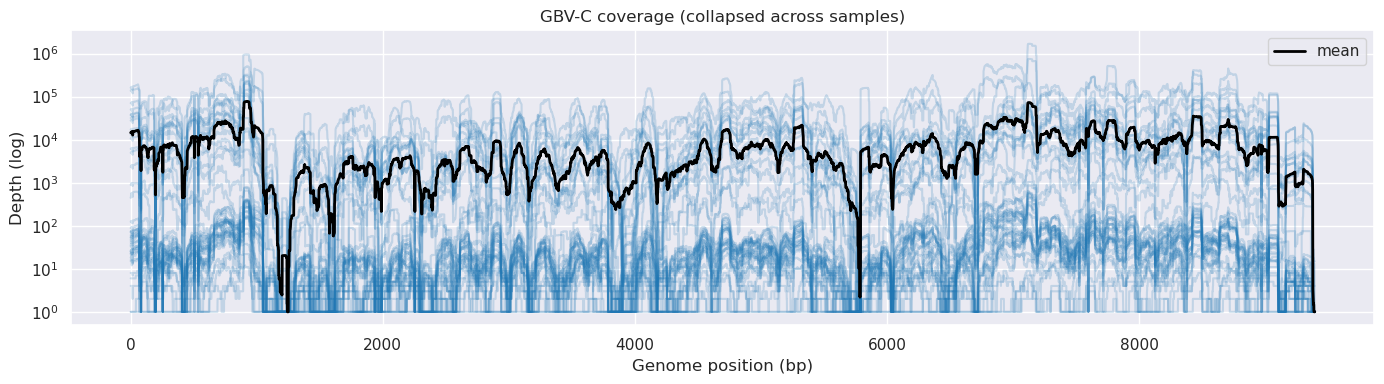

In [173]:
GBVC_REF = "NC_001710.1"
gbvc_dfs = load_depths("../tables/align_hcv_gbvc_tsv/*.GBVC.depth.tsv", ref=GBVC_REF)

all_gbvc = pd.concat(gbvc_dfs)
mean_gbvc = all_gbvc.groupby("pos")["depth"].mean().reset_index()

plt.figure(figsize=(14,4))
for df in gbvc_dfs:
    plt.plot(df["pos"], np.maximum(df["depth"],1), color="tab:blue", alpha=0.2)

plt.plot(mean_gbvc["pos"], np.maximum(mean_gbvc["depth"],1),
         color="black", linewidth=2, label="mean")

plt.yscale("log")
plt.xlabel("Genome position (bp)")
plt.ylabel("Depth (log)")
plt.title("GBV-C coverage (collapsed across samples)")
plt.legend()
plt.tight_layout()
os.makedirs("../figures/sfigures/sfigure14/panel_B/", exist_ok=True)
plt.savefig('../figures/sfigures/sfigure14/panel_B/coverage_across_gbvc.svg')
plt.show()

